In [1]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import gc
import seaborn as sns
import re
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.impute import SimpleImputer
from tensorflow.keras import optimizers
from tensorflow.keras import layers,Model
from sklearn.model_selection import KFold,cross_validate

from sklearn import ensemble,tree
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestRegressor
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import clone

In [2]:
def PrintAll(x):
    pd.set_option('display.max_rows',len(x))
    print(x)
    pd.set_option('display.max_rows',10)

In [3]:
def RunKfold(model,trainX,trainY):       
    kf = KFold(n_splits=10, shuffle = True)
    fold_accuracy = []
    i = 1
    for train_index, test_index in kf.split(trainData):   
        m = clone(model)
        m.fit(trainX[train_index],trainY[train_index])
        predict = m.predict(trainX[test_index])        
        test_acc = accuracy_score(predict,trainY[test_index])
        print("Fold {} : {}".format(i,test_acc))
        fold_accuracy.append(test_acc)
        i+=1
    print("Avg acc : {}".format(sum(fold_accuracy)/len(fold_accuracy)))
def Train(model,trainX,trainY):    
    model.fit(trainX,trainY)
    print("Train accuracy : {}".format(model.score(trainX,trainY)))
    
def Prediction(model,testX,name):
    predictions = model.predict(testX)
    submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
    submission.to_csv(name,index = False)
    print("Write to csv finished!")


In [4]:
def DummyData(data, columns):
    for c in columns:
        data = pd.concat([data,pd.get_dummies(data[c],prefix = c)],axis = 1)
        data = data.drop(c,axis = 1)
    return data

In [5]:
# import data
trainData = pd.read_csv('train.csv',header = 0)
testData = pd.read_csv('test.csv',header = 0)
pId = testData['PassengerId']

trainData.drop(['Ticket','PassengerId'],axis = 1,inplace = True)
testData.drop(['Ticket','PassengerId'],axis = 1,inplace = True)


print("Train data number : {}".format(trainData.shape[0]))
print("Test data number : {}".format(testData.shape[0])) 
print("Survived : {}".format((trainData['Survived'] == 1).sum()))
print("Dead : {}".format((trainData['Survived'] == 0).sum()))
print("Survived ratio : {}".format((trainData['Survived'] == 1).sum() / trainData['Survived'].count()))

Train data number : 891
Test data number : 418
Survived : 342
Dead : 549
Survived ratio : 0.3838383838383838


In [6]:
# Check missing data
def MissingData(data):
    total = data.isnull().count()
    count = data.isnull().sum()
    missingData = pd.DataFrame({'percent(%)':count/total * 100})
    PrintAll(missingData)
MissingData(trainData)
MissingData(testData)

          percent(%)
Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age        19.865320
SibSp       0.000000
Parch       0.000000
Fare        0.000000
Cabin      77.104377
Embarked    0.224467
          percent(%)
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age        20.574163
SibSp       0.000000
Parch       0.000000
Fare        0.239234
Cabin      78.229665
Embarked    0.000000


In [7]:
# Has Cabin
trainData['HasCabin'] = trainData['Cabin'].apply(lambda x:0 if type(x) == float else 1)
testData['HasCabin'] = testData['Cabin'].apply(lambda x:0 if type(x) == float else 1)

trainData.drop(['Cabin'],axis = 1,inplace = True)
testData.drop('Cabin',axis = 1,inplace = True)

trainData.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,0


In [8]:
# Filled Embark 
trainData['Embarked'].fillna(trainData['Embarked'].mode()[0],inplace = True)
testData['Embarked'].fillna(testData['Embarked'].mode()[0],inplace = True)

In [9]:
# Check missing test data
MissingData(trainData)
MissingData(testData)

          percent(%)
Survived     0.00000
Pclass       0.00000
Name         0.00000
Sex          0.00000
Age         19.86532
SibSp        0.00000
Parch        0.00000
Fare         0.00000
Embarked     0.00000
HasCabin     0.00000
          percent(%)
Pclass      0.000000
Name        0.000000
Sex         0.000000
Age        20.574163
SibSp       0.000000
Parch       0.000000
Fare        0.239234
Embarked    0.000000
HasCabin    0.000000


In [10]:
# Print all title
def GetTitle(name):
    title = re.search(" ([A-Za-z]+)\. ",name)
    if title:        
        return title.group(1)
    else:
        return 0
# Add title
def NameToTitle(data):    
    data['Title'] = data['Title'].replace(['Mile','Ms','Lady'],'Miss')    
    data['Title'] = data['Title'].replace('Mme','Mrs')    
    data['Title'] = data["Title"].replace(['Rev','Dr','Col','Mlle','Major','Dona','Don','Countess','Capt','Sir','Jonkheer'],'Rare')    
    return data


trainData["Title"] = trainData['Name'].apply(GetTitle)
testData["Title"] =  testData['Name'].apply(GetTitle)

trainData = NameToTitle(trainData)
testData = NameToTitle(testData)

title = pd.concat([trainData['Title'],testData['Title']]).value_counts()
PrintAll(title)

trainData.drop('Name',axis = 1,inplace = True)
testData.drop('Name',axis = 1,inplace = True)

Mr        757
Miss      263
Mrs       198
Master     61
Rare       30
Name: Title, dtype: int64


In [11]:
def ConvertSex(data):
    le = LabelEncoder()
    le.fit(['male','female'])
    data['Sex'] = le.transform(data['Sex'])
    return
ConvertSex(trainData)
ConvertSex(testData)

trainData.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,HasCabin,Title
0,0,3,1,22.0,1,0,7.2500,S,0,Mr
1,1,1,0,38.0,1,0,71.2833,C,1,Mrs
2,1,3,0,26.0,0,0,7.9250,S,0,Miss
3,1,1,0,35.0,1,0,53.1000,S,1,Mrs
4,0,3,1,35.0,0,0,8.0500,S,0,Mr


In [12]:
columns = ['Pclass','Embarked','Title']
trainData = DummyData(trainData,columns)
testData = DummyData(testData,columns)

trainData.head()

,Survived,Sex,Age,SibSp,Parch,Fare,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare
0,0,1,22.0,1,0,7.2500,0,0,0,1,0,0,1,0,0,1,0,0
1,1,0,38.0,1,0,71.2833,1,1,0,0,1,0,0,0,0,0,1,0
2,1,0,26.0,0,0,7.9250,0,0,0,1,0,0,1,0,1,0,0,0
3,1,0,35.0,1,0,53.1000,1,1,0,0,0,0,1,0,0,0,1,0
4,0,1,35.0,0,0,8.0500,0,0,0,1,0,0,1,0,0,1,0,0


In [13]:
# Family size
trainData['FamilySize'] = trainData['SibSp'] + trainData['Parch'] + 1
testData['FamilySize'] = testData['SibSp'] + testData['Parch'] + 1

trainData['IsAlone'] = trainData['FamilySize'].apply(lambda x: 1 if x==1 else 0)
testData['IsAlone'] = testData['FamilySize'].apply(lambda x: 1 if x==1 else 0)


trainData.head()

,Survived,Sex,Age,SibSp,Parch,Fare,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone
0,0,1,22.0,1,0,7.2500,0,0,0,1,0,0,1,0,0,1,0,0,2,0
1,1,0,38.0,1,0,71.2833,1,1,0,0,1,0,0,0,0,0,1,0,2,0
2,1,0,26.0,0,0,7.9250,0,0,0,1,0,0,1,0,1,0,0,0,1,1
3,1,0,35.0,1,0,53.1000,1,1,0,0,0,0,1,0,0,0,1,0,2,0
4,0,1,35.0,0,0,8.0500,0,0,0,1,0,0,1,0,0,1,0,0,1,1


In [14]:
# Change age
trainData['AgeRange'] = trainData[trainData['Age'].notnull()]['Age'].apply(lambda x: int(x/25))
testData['AgeRange'] = testData[testData['Age'].notnull()]['Age'].apply(lambda x: int(x/25))
trainData.drop('Age',axis = 1,inplace = True)
testData.drop('Age',axis = 1,inplace = True)
trainData.head()

,Survived,Sex,SibSp,Parch,Fare,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone,AgeRange
0,0,1,1,0,7.2500,0,0,0,1,0,0,1,0,0,1,0,0,2,0,0.0
1,1,0,1,0,71.2833,1,1,0,0,1,0,0,0,0,0,1,0,2,0,1.0
2,1,0,0,0,7.9250,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1.0
3,1,0,1,0,53.1000,1,1,0,0,0,0,1,0,0,0,1,0,2,0,1.0
4,0,1,0,0,8.0500,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1.0


,Survived,Sex,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,2,0,0.0,0
1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,2,0,1.0,2
2,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1.0,0
3,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,2,0,1.0,2
4,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1.0,0


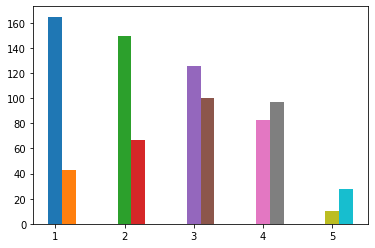

In [15]:
j = 0
k = 0
for i in [7.91,14.45,31,120,float('inf')]:
    k+=1
    plt.bar(k,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==0)).sum(),0.2)
    plt.bar(k+0.2,((trainData['Fare']<i) & (trainData['Fare']>j) & (trainData['Survived']==1)).sum(),0.2)
    j = i

    


trainData.head()
# Change fare
def ConvertFare(fare):
    if fare < 7.91:
        return 0
    elif fare < 14:
        return 1
    elif fare < 14.45:
        return 2
    elif fair < 31:
        return 3
    elif fair < 120:
        return 4
    else:
        return 5        
    

trainData['FareRange'] = trainData[trainData['Fare'].notnull()]['Fare'].apply(lambda x: int(x/25))
testData['FareRange'] = testData[testData['Fare'].notnull()]['Fare'].apply(lambda x: int(x/25))

trainData.drop('Fare',axis = 1,inplace = True)
testData.drop('Fare',axis = 1,inplace = True)
trainData.head()

In [16]:
# Deal with missing values
def nan_padding(train,test, columns):      
    train_num = trainData.shape[0]
    test_num = testData.shape[0]
    for c in columns:
        data = pd.concat([train.drop(['Survived'],axis = 1),test])
        
        forest = RandomForestClassifier(n_estimators = 500,max_depth = 5)        
        for cname in columns:
            if c == cname:
                continue
            data[cname].fillna(data[cname].mode()[0],inplace = True)
            
        ty = data[data[c].notnull()][c].to_numpy()    
        tx = data[data[c].notnull()].drop(c,axis = 1).to_numpy()                
        RunKfold(forest, tx,ty)
        
        forest.fit(tx,ty)
        predict = forest.predict(data[data[c].isnull()].drop(c,axis = 1))                
        data.loc[data[c].isnull(),c] = predict
                
        train[c] = data.loc[:,c].iloc[:train_num]                
        test[c] = data.loc[:,c].iloc[train_num:]  
    return train,test

columns = ["AgeRange","FareRange"]
trainData,testData = nan_padding(trainData,testData, columns)

trainData.head()

Fold 1 : 0.6333333333333333
Fold 2 : 0.6629213483146067
Fold 3 : 0.6966292134831461
Fold 4 : 0.7528089887640449
Fold 5 : 0.6741573033707865
Fold 6 : 0.5730337078651685
Fold 7 : 0.5842696629213483
Fold 8 : 0.5730337078651685
Fold 9 : 0.6853932584269663
Fold 10 : 0.6292134831460674
Avg acc : 0.6464794007490636
Fold 1 : 0.8333333333333334
Fold 2 : 0.7415730337078652
Fold 3 : 0.7865168539325843
Fold 4 : 0.8426966292134831
Fold 5 : 0.8764044943820225
Fold 6 : 0.7865168539325843
Fold 7 : 0.8089887640449438
Fold 8 : 0.8202247191011236
Fold 9 : 0.7865168539325843
Fold 10 : 0.9101123595505618
Avg acc : 0.8192883895131086


,Survived,Sex,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,2,0,0.0,0.0
1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,2,0,1.0,2.0
2,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1.0,0.0
3,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,2,0,1.0,2.0
4,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1.0,0.0


In [17]:
# Check missing test data
MissingData(trainData)
MissingData(testData)

              percent(%)
Survived             0.0
Sex                  0.0
SibSp                0.0
Parch                0.0
HasCabin             0.0
Pclass_1             0.0
Pclass_2             0.0
Pclass_3             0.0
Embarked_C           0.0
Embarked_Q           0.0
Embarked_S           0.0
Title_Master         0.0
Title_Miss           0.0
Title_Mr             0.0
Title_Mrs            0.0
Title_Rare           0.0
FamilySize           0.0
IsAlone              0.0
AgeRange             0.0
FareRange            0.0
              percent(%)
Sex                  0.0
SibSp                0.0
Parch                0.0
HasCabin             0.0
Pclass_1             0.0
Pclass_2             0.0
Pclass_3             0.0
Embarked_C           0.0
Embarked_Q           0.0
Embarked_S           0.0
Title_Master         0.0
Title_Miss           0.0
Title_Mr             0.0
Title_Mrs            0.0
Title_Rare           0.0
FamilySize           0.0
IsAlone              0.0
AgeRange             0.0


In [18]:
def NormalizeData(data,columns):
    scaler = MinMaxScaler()
    for c in columns:
        data[c] = scaler.fit_transform(data[c].values.reshape(-1,1))
    return data


#columns = ['Fare','Age']
#trainData = NormalizeData(trainData,columns)
#testData = NormalizeData(testData,columns)
#trainData.head()

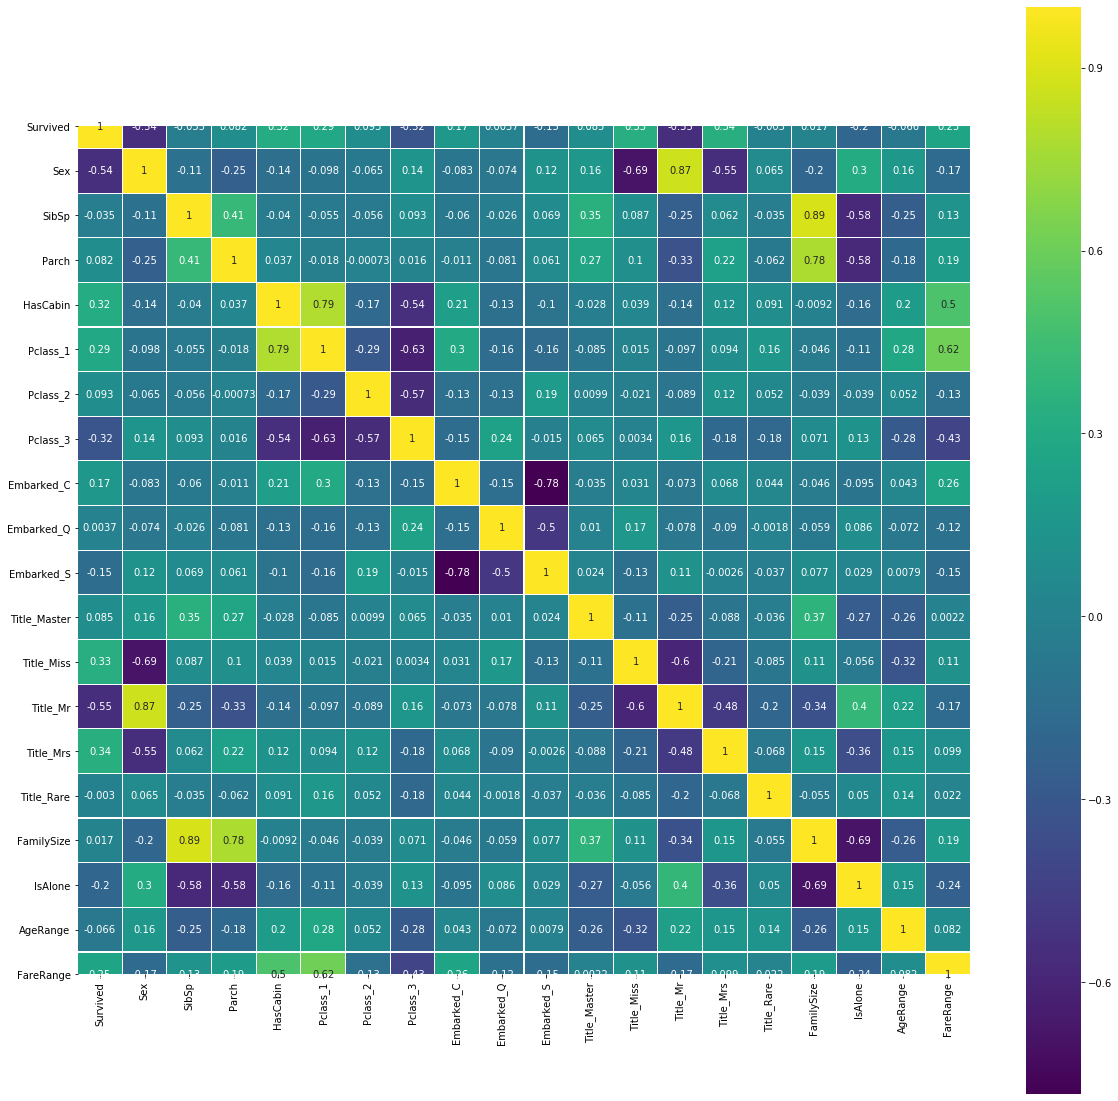

In [19]:
# Visualize co-relation
colormap = plt.cm.viridis
plt.figure(figsize=(20,20))
#plt.title("Correlation of Features")
sns.heatmap(trainData.astype(float).corr(),linewidths=0.1,vmax=1.0,square = True, cmap=colormap,linecolor='white',annot=True)

In [20]:
# Drop data with low co-relation
columns = ['Title_Rare','Embarked_C']
#trainData = DropColumn(trainData,columns)
#testData = DropColumn(testData,columns)


In [21]:
trainData.head()

,Survived,Sex,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone,AgeRange,FareRange
0,0,1,1,0,0,0,0,1,0,0,1,0,0,1,0,0,2,0,0.0,0.0
1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,2,0,1.0,2.0
2,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,1,1.0,0.0
3,1,0,1,0,1,1,0,0,0,0,1,0,0,0,1,0,2,0,1.0,2.0
4,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1.0,0.0


In [22]:
testData.head()

,Sex,SibSp,Parch,HasCabin,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rare,FamilySize,IsAlone,AgeRange,FareRange
0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,1.0,0.0
1,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,2,0,1.0,0.0
2,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,2.0,0.0
3,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,1.0,0.0
4,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,3,0,0.0,0.0


In [23]:
trainX = trainData.iloc[:,1:].to_numpy()
trainY = trainData.loc[:,'Survived'].to_numpy()
testX = testData.iloc[:,:].to_numpy()

In [24]:
# Deep Learning

In [25]:
# Check point
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath = "./checkpoint.ckpt" , 
                                                 save_weights_only = True,
                                                 save_best_only = True,
                                                 peroid=5, 
                                                 verbose = 1)

In [26]:
def CreateModel():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = 1024, 
                              activation = 'relu', 
                              input_shape=(trainX.shape[1],), 
                              kernel_regularizer = tf.keras.regularizers.l2(0.01)),  
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),        
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)), 
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(units = 1024, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(0.01)),                
        tf.keras.layers.Dropout(0.3), 
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    return model

In [27]:
model = CreateModel()
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              20480     
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0

Train on 801 samples, validate on 90 samples
Epoch 1/500

Epoch 00001: val_loss improved from inf to 27.78215, saving model to ./checkpoint.ckpt
801/801 - 4s - loss: 29.9077 - accuracy: 0.6217 - val_loss: 27.7822 - val_accuracy: 0.7000
Epoch 2/500

Epoch 00002: val_loss improved from 27.78215 to 24.26201, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 26.1433 - accuracy: 0.6742 - val_loss: 24.2620 - val_accuracy: 0.7667
Epoch 3/500

Epoch 00003: val_loss improved from 24.26201 to 21.19655, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 22.8251 - accuracy: 0.7366 - val_loss: 21.1965 - val_accuracy: 0.7556
Epoch 4/500

Epoch 00004: val_loss improved from 21.19655 to 18.50572, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 19.9300 - accuracy: 0.7790 - val_loss: 18.5057 - val_accuracy: 0.8000
Epoch 5/500

Epoch 00005: val_loss improved from 18.50572 to 16.19417, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 17.4177 - accuracy: 0.8015 - val_loss: 16.1942 - v

Epoch 44/500

Epoch 00044: val_loss did not improve from 0.64387
801/801 - 1s - loss: 0.6391 - accuracy: 0.8414 - val_loss: 0.6566 - val_accuracy: 0.8222
Epoch 45/500

Epoch 00045: val_loss improved from 0.64387 to 0.62015, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 0.6314 - accuracy: 0.8402 - val_loss: 0.6202 - val_accuracy: 0.8333
Epoch 46/500

Epoch 00046: val_loss did not improve from 0.62015
801/801 - 1s - loss: 0.6180 - accuracy: 0.8390 - val_loss: 0.6323 - val_accuracy: 0.8222
Epoch 47/500

Epoch 00047: val_loss improved from 0.62015 to 0.60444, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 0.6120 - accuracy: 0.8452 - val_loss: 0.6044 - val_accuracy: 0.8222
Epoch 48/500

Epoch 00048: val_loss did not improve from 0.60444
801/801 - 1s - loss: 0.6024 - accuracy: 0.8265 - val_loss: 0.6046 - val_accuracy: 0.8222
Epoch 49/500

Epoch 00049: val_loss improved from 0.60444 to 0.59053, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 0.6065 - accuracy: 0.8265 -

Epoch 93/500

Epoch 00093: val_loss did not improve from 0.49944
801/801 - 1s - loss: 0.5042 - accuracy: 0.8315 - val_loss: 0.5095 - val_accuracy: 0.8222
Epoch 94/500

Epoch 00094: val_loss did not improve from 0.49944
801/801 - 1s - loss: 0.5051 - accuracy: 0.8340 - val_loss: 0.5224 - val_accuracy: 0.8222
Epoch 95/500

Epoch 00095: val_loss improved from 0.49944 to 0.49703, saving model to ./checkpoint.ckpt
801/801 - 2s - loss: 0.5057 - accuracy: 0.8340 - val_loss: 0.4970 - val_accuracy: 0.8222
Epoch 96/500

Epoch 00096: val_loss improved from 0.49703 to 0.49437, saving model to ./checkpoint.ckpt
801/801 - 3s - loss: 0.5034 - accuracy: 0.8365 - val_loss: 0.4944 - val_accuracy: 0.8222
Epoch 97/500

Epoch 00097: val_loss did not improve from 0.49437
801/801 - 1s - loss: 0.4977 - accuracy: 0.8427 - val_loss: 0.5312 - val_accuracy: 0.8333
Epoch 98/500

Epoch 00098: val_loss did not improve from 0.49437
801/801 - 1s - loss: 0.5083 - accuracy: 0.8327 - val_loss: 0.4974 - val_accuracy: 0.822

Epoch 145/500

Epoch 00145: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4744 - accuracy: 0.8439 - val_loss: 0.4820 - val_accuracy: 0.8222
Epoch 146/500

Epoch 00146: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4692 - accuracy: 0.8427 - val_loss: 0.5191 - val_accuracy: 0.8000
Epoch 147/500

Epoch 00147: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4748 - accuracy: 0.8439 - val_loss: 0.4786 - val_accuracy: 0.8000
Epoch 148/500

Epoch 00148: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4730 - accuracy: 0.8452 - val_loss: 0.4979 - val_accuracy: 0.8222
Epoch 149/500

Epoch 00149: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4688 - accuracy: 0.8514 - val_loss: 0.4833 - val_accuracy: 0.8111
Epoch 150/500

Epoch 00150: val_loss did not improve from 0.47265
801/801 - 1s - loss: 0.4713 - accuracy: 0.8439 - val_loss: 0.4794 - val_accuracy: 0.8333
Epoch 151/500

Epoch 00151: val_loss did not improve from 0.47265
801/

Epoch 198/500

Epoch 00198: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4623 - accuracy: 0.8514 - val_loss: 0.4920 - val_accuracy: 0.8111
Epoch 199/500

Epoch 00199: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4716 - accuracy: 0.8402 - val_loss: 0.4750 - val_accuracy: 0.8111
Epoch 200/500

Epoch 00200: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4590 - accuracy: 0.8377 - val_loss: 0.4874 - val_accuracy: 0.8111
Epoch 201/500

Epoch 00201: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4586 - accuracy: 0.8514 - val_loss: 0.4740 - val_accuracy: 0.8222
Epoch 202/500

Epoch 00202: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4604 - accuracy: 0.8427 - val_loss: 0.4805 - val_accuracy: 0.8222
Epoch 203/500

Epoch 00203: val_loss did not improve from 0.45621
801/801 - 1s - loss: 0.4556 - accuracy: 0.8502 - val_loss: 0.5147 - val_accuracy: 0.7889
Epoch 204/500

Epoch 00204: val_loss did not improve from 0.45621
801/

Epoch 251/500

Epoch 00251: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4468 - accuracy: 0.8464 - val_loss: 0.4827 - val_accuracy: 0.8222
Epoch 252/500

Epoch 00252: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4514 - accuracy: 0.8477 - val_loss: 0.4716 - val_accuracy: 0.8222
Epoch 253/500

Epoch 00253: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4458 - accuracy: 0.8489 - val_loss: 0.4824 - val_accuracy: 0.8222
Epoch 254/500

Epoch 00254: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4514 - accuracy: 0.8452 - val_loss: 0.4724 - val_accuracy: 0.8222
Epoch 255/500

Epoch 00255: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4460 - accuracy: 0.8552 - val_loss: 0.4798 - val_accuracy: 0.8222
Epoch 256/500

Epoch 00256: val_loss did not improve from 0.44792
801/801 - 1s - loss: 0.4554 - accuracy: 0.8439 - val_loss: 0.4559 - val_accuracy: 0.8444
Epoch 257/500

Epoch 00257: val_loss did not improve from 0.44792
801/

Epoch 304/500

Epoch 00304: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4468 - accuracy: 0.8452 - val_loss: 0.4772 - val_accuracy: 0.8222
Epoch 305/500

Epoch 00305: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4449 - accuracy: 0.8464 - val_loss: 0.4529 - val_accuracy: 0.8222
Epoch 306/500

Epoch 00306: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4453 - accuracy: 0.8464 - val_loss: 0.4509 - val_accuracy: 0.8222
Epoch 307/500

Epoch 00307: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4503 - accuracy: 0.8377 - val_loss: 0.4782 - val_accuracy: 0.8111
Epoch 308/500

Epoch 00308: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4414 - accuracy: 0.8464 - val_loss: 0.4625 - val_accuracy: 0.8111
Epoch 309/500

Epoch 00309: val_loss did not improve from 0.44777
801/801 - 1s - loss: 0.4445 - accuracy: 0.8414 - val_loss: 0.4667 - val_accuracy: 0.8222
Epoch 310/500

Epoch 00310: val_loss did not improve from 0.44777
801/

Epoch 357/500

Epoch 00357: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4436 - accuracy: 0.8514 - val_loss: 0.4773 - val_accuracy: 0.8111
Epoch 358/500

Epoch 00358: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4465 - accuracy: 0.8502 - val_loss: 0.4679 - val_accuracy: 0.8111
Epoch 359/500

Epoch 00359: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4409 - accuracy: 0.8502 - val_loss: 0.4680 - val_accuracy: 0.7889
Epoch 360/500

Epoch 00360: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4404 - accuracy: 0.8552 - val_loss: 0.4955 - val_accuracy: 0.7889
Epoch 361/500

Epoch 00361: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4431 - accuracy: 0.8439 - val_loss: 0.4853 - val_accuracy: 0.7778
Epoch 362/500

Epoch 00362: val_loss did not improve from 0.44063
801/801 - 1s - loss: 0.4416 - accuracy: 0.8477 - val_loss: 0.4680 - val_accuracy: 0.8000
Epoch 363/500

Epoch 00363: val_loss did not improve from 0.44063
801/

Epoch 410/500

Epoch 00410: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4383 - accuracy: 0.8452 - val_loss: 0.4732 - val_accuracy: 0.8111
Epoch 411/500

Epoch 00411: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4294 - accuracy: 0.8564 - val_loss: 0.4661 - val_accuracy: 0.8000
Epoch 412/500

Epoch 00412: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4293 - accuracy: 0.8539 - val_loss: 0.4426 - val_accuracy: 0.8111
Epoch 413/500

Epoch 00413: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4341 - accuracy: 0.8514 - val_loss: 0.4601 - val_accuracy: 0.8111
Epoch 414/500

Epoch 00414: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4266 - accuracy: 0.8527 - val_loss: 0.4463 - val_accuracy: 0.8111
Epoch 415/500

Epoch 00415: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4325 - accuracy: 0.8489 - val_loss: 0.4654 - val_accuracy: 0.8000
Epoch 416/500

Epoch 00416: val_loss did not improve from 0.43338
801/

Epoch 463/500

Epoch 00463: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4315 - accuracy: 0.8477 - val_loss: 0.4759 - val_accuracy: 0.8000
Epoch 464/500

Epoch 00464: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4296 - accuracy: 0.8514 - val_loss: 0.4722 - val_accuracy: 0.8000
Epoch 465/500

Epoch 00465: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4280 - accuracy: 0.8502 - val_loss: 0.4702 - val_accuracy: 0.8000
Epoch 466/500

Epoch 00466: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4377 - accuracy: 0.8489 - val_loss: 0.4594 - val_accuracy: 0.8111
Epoch 467/500

Epoch 00467: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4403 - accuracy: 0.8527 - val_loss: 0.4594 - val_accuracy: 0.8000
Epoch 468/500

Epoch 00468: val_loss did not improve from 0.43338
801/801 - 1s - loss: 0.4329 - accuracy: 0.8464 - val_loss: 0.4868 - val_accuracy: 0.7889
Epoch 469/500

Epoch 00469: val_loss did not improve from 0.43338
801/

Epoch 16/500

Epoch 00016: val_loss did not improve from 0.43338
802/802 - 1s - loss: 4.0774 - accuracy: 0.8254 - val_loss: 3.8107 - val_accuracy: 0.8090
Epoch 17/500

Epoch 00017: val_loss did not improve from 0.43338
802/802 - 1s - loss: 3.5922 - accuracy: 0.8354 - val_loss: 3.3713 - val_accuracy: 0.8090
Epoch 18/500

Epoch 00018: val_loss did not improve from 0.43338
802/802 - 1s - loss: 3.1872 - accuracy: 0.8180 - val_loss: 3.0027 - val_accuracy: 0.8090
Epoch 19/500

Epoch 00019: val_loss did not improve from 0.43338
802/802 - 1s - loss: 2.8374 - accuracy: 0.8192 - val_loss: 2.6748 - val_accuracy: 0.8090
Epoch 20/500

Epoch 00020: val_loss did not improve from 0.43338
802/802 - 1s - loss: 2.5296 - accuracy: 0.8192 - val_loss: 2.4137 - val_accuracy: 0.7865
Epoch 21/500

Epoch 00021: val_loss did not improve from 0.43338
802/802 - 1s - loss: 2.2677 - accuracy: 0.8204 - val_loss: 2.1470 - val_accuracy: 0.8090
Epoch 22/500

Epoch 00022: val_loss did not improve from 0.43338
802/802 - 1

Epoch 70/500

Epoch 00070: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5366 - accuracy: 0.8404 - val_loss: 0.5554 - val_accuracy: 0.8090
Epoch 71/500

Epoch 00071: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5289 - accuracy: 0.8279 - val_loss: 0.5556 - val_accuracy: 0.8090
Epoch 72/500

Epoch 00072: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5255 - accuracy: 0.8379 - val_loss: 0.5388 - val_accuracy: 0.8202
Epoch 73/500

Epoch 00073: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5227 - accuracy: 0.8317 - val_loss: 0.5423 - val_accuracy: 0.8090
Epoch 74/500

Epoch 00074: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5189 - accuracy: 0.8392 - val_loss: 0.5381 - val_accuracy: 0.8202
Epoch 75/500

Epoch 00075: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5225 - accuracy: 0.8342 - val_loss: 0.5344 - val_accuracy: 0.8315
Epoch 76/500

Epoch 00076: val_loss did not improve from 0.43338
802/802 - 1


Epoch 00123: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4715 - accuracy: 0.8416 - val_loss: 0.5046 - val_accuracy: 0.8090
Epoch 124/500

Epoch 00124: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4723 - accuracy: 0.8466 - val_loss: 0.5014 - val_accuracy: 0.8090
Epoch 125/500

Epoch 00125: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4808 - accuracy: 0.8317 - val_loss: 0.5103 - val_accuracy: 0.8090
Epoch 126/500

Epoch 00126: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4747 - accuracy: 0.8379 - val_loss: 0.5067 - val_accuracy: 0.8202
Epoch 127/500

Epoch 00127: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4680 - accuracy: 0.8491 - val_loss: 0.5128 - val_accuracy: 0.8202
Epoch 128/500

Epoch 00128: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4751 - accuracy: 0.8367 - val_loss: 0.5058 - val_accuracy: 0.8202
Epoch 129/500

Epoch 00129: val_loss did not improve from 0.43338
802/802 - 1s - los

Epoch 176/500

Epoch 00176: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4526 - accuracy: 0.8516 - val_loss: 0.5054 - val_accuracy: 0.8090
Epoch 177/500

Epoch 00177: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4645 - accuracy: 0.8354 - val_loss: 0.4978 - val_accuracy: 0.8202
Epoch 178/500

Epoch 00178: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4731 - accuracy: 0.8267 - val_loss: 0.4911 - val_accuracy: 0.8202
Epoch 179/500

Epoch 00179: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4684 - accuracy: 0.8379 - val_loss: 0.4923 - val_accuracy: 0.8090
Epoch 180/500

Epoch 00180: val_loss did not improve from 0.43338
802/802 - 2s - loss: 0.4567 - accuracy: 0.8429 - val_loss: 0.5015 - val_accuracy: 0.8090
Epoch 181/500

Epoch 00181: val_loss did not improve from 0.43338
802/802 - 2s - loss: 0.4544 - accuracy: 0.8491 - val_loss: 0.4932 - val_accuracy: 0.8090
Epoch 182/500

Epoch 00182: val_loss did not improve from 0.43338
802/

Epoch 229/500

Epoch 00229: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4470 - accuracy: 0.8516 - val_loss: 0.5010 - val_accuracy: 0.8090
Epoch 230/500

Epoch 00230: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4459 - accuracy: 0.8529 - val_loss: 0.4939 - val_accuracy: 0.8202
Epoch 231/500

Epoch 00231: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4450 - accuracy: 0.8491 - val_loss: 0.4902 - val_accuracy: 0.8090
Epoch 232/500

Epoch 00232: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4381 - accuracy: 0.8603 - val_loss: 0.4954 - val_accuracy: 0.8202
Epoch 233/500

Epoch 00233: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4388 - accuracy: 0.8516 - val_loss: 0.4932 - val_accuracy: 0.8202
Epoch 234/500

Epoch 00234: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4528 - accuracy: 0.8379 - val_loss: 0.4870 - val_accuracy: 0.8090
Epoch 235/500

Epoch 00235: val_loss did not improve from 0.43338
802/

Epoch 282/500

Epoch 00282: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4424 - accuracy: 0.8454 - val_loss: 0.4809 - val_accuracy: 0.8202
Epoch 283/500

Epoch 00283: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4384 - accuracy: 0.8416 - val_loss: 0.5058 - val_accuracy: 0.8090
Epoch 284/500

Epoch 00284: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4477 - accuracy: 0.8379 - val_loss: 0.4888 - val_accuracy: 0.8202
Epoch 285/500

Epoch 00285: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4386 - accuracy: 0.8554 - val_loss: 0.4952 - val_accuracy: 0.8202
Epoch 286/500

Epoch 00286: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4381 - accuracy: 0.8429 - val_loss: 0.4804 - val_accuracy: 0.8202
Epoch 287/500

Epoch 00287: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4370 - accuracy: 0.8516 - val_loss: 0.4901 - val_accuracy: 0.8202
Epoch 288/500

Epoch 00288: val_loss did not improve from 0.43338
802/

Epoch 335/500

Epoch 00335: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4317 - accuracy: 0.8591 - val_loss: 0.5071 - val_accuracy: 0.8090
Epoch 336/500

Epoch 00336: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4367 - accuracy: 0.8491 - val_loss: 0.4858 - val_accuracy: 0.8202
Epoch 337/500

Epoch 00337: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4351 - accuracy: 0.8566 - val_loss: 0.4815 - val_accuracy: 0.8202
Epoch 338/500

Epoch 00338: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4258 - accuracy: 0.8579 - val_loss: 0.4834 - val_accuracy: 0.8202
Epoch 339/500

Epoch 00339: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4323 - accuracy: 0.8554 - val_loss: 0.4935 - val_accuracy: 0.7978
Epoch 340/500

Epoch 00340: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4332 - accuracy: 0.8628 - val_loss: 0.4843 - val_accuracy: 0.8202
Epoch 341/500

Epoch 00341: val_loss did not improve from 0.43338
802/

Epoch 388/500

Epoch 00388: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4231 - accuracy: 0.8603 - val_loss: 0.4822 - val_accuracy: 0.8202
Epoch 389/500

Epoch 00389: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4207 - accuracy: 0.8591 - val_loss: 0.4791 - val_accuracy: 0.8090
Epoch 390/500

Epoch 00390: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4245 - accuracy: 0.8441 - val_loss: 0.4825 - val_accuracy: 0.7978
Epoch 391/500

Epoch 00391: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4287 - accuracy: 0.8466 - val_loss: 0.4834 - val_accuracy: 0.8090
Epoch 392/500

Epoch 00392: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4219 - accuracy: 0.8566 - val_loss: 0.4892 - val_accuracy: 0.7978
Epoch 393/500

Epoch 00393: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4271 - accuracy: 0.8516 - val_loss: 0.4826 - val_accuracy: 0.8090
Epoch 394/500

Epoch 00394: val_loss did not improve from 0.43338
802/

Epoch 441/500

Epoch 00441: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4167 - accuracy: 0.8491 - val_loss: 0.4907 - val_accuracy: 0.8090
Epoch 442/500

Epoch 00442: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4225 - accuracy: 0.8591 - val_loss: 0.4827 - val_accuracy: 0.8090
Epoch 443/500

Epoch 00443: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4147 - accuracy: 0.8579 - val_loss: 0.4812 - val_accuracy: 0.8090
Epoch 444/500

Epoch 00444: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4446 - accuracy: 0.8416 - val_loss: 0.4803 - val_accuracy: 0.8090
Epoch 445/500

Epoch 00445: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4331 - accuracy: 0.8516 - val_loss: 0.4862 - val_accuracy: 0.8202
Epoch 446/500

Epoch 00446: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4269 - accuracy: 0.8529 - val_loss: 0.4848 - val_accuracy: 0.7978
Epoch 447/500

Epoch 00447: val_loss did not improve from 0.43338
802/

Epoch 494/500

Epoch 00494: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4152 - accuracy: 0.8541 - val_loss: 0.4842 - val_accuracy: 0.8202
Epoch 495/500

Epoch 00495: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4189 - accuracy: 0.8541 - val_loss: 0.4840 - val_accuracy: 0.8202
Epoch 496/500

Epoch 00496: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4160 - accuracy: 0.8554 - val_loss: 0.4797 - val_accuracy: 0.8202
Epoch 497/500

Epoch 00497: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4127 - accuracy: 0.8591 - val_loss: 0.4919 - val_accuracy: 0.8315
Epoch 498/500

Epoch 00498: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4121 - accuracy: 0.8554 - val_loss: 0.4899 - val_accuracy: 0.8315
Epoch 499/500

Epoch 00499: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4166 - accuracy: 0.8641 - val_loss: 0.4901 - val_accuracy: 0.8090
Epoch 500/500

Epoch 00500: val_loss did not improve from 0.43338
802/

Epoch 47/500

Epoch 00047: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6063 - accuracy: 0.8454 - val_loss: 0.7525 - val_accuracy: 0.7640
Epoch 48/500

Epoch 00048: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5927 - accuracy: 0.8404 - val_loss: 0.7469 - val_accuracy: 0.7416
Epoch 49/500

Epoch 00049: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5907 - accuracy: 0.8454 - val_loss: 0.7384 - val_accuracy: 0.7640
Epoch 50/500

Epoch 00050: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5841 - accuracy: 0.8479 - val_loss: 0.7422 - val_accuracy: 0.7528
Epoch 51/500

Epoch 00051: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5755 - accuracy: 0.8404 - val_loss: 0.7452 - val_accuracy: 0.7640
Epoch 52/500

Epoch 00052: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5761 - accuracy: 0.8392 - val_loss: 0.7169 - val_accuracy: 0.7528
Epoch 53/500

Epoch 00053: val_loss did not improve from 0.43338
802/802 - 1

Epoch 101/500

Epoch 00101: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4715 - accuracy: 0.8466 - val_loss: 0.6487 - val_accuracy: 0.7753
Epoch 102/500

Epoch 00102: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4709 - accuracy: 0.8504 - val_loss: 0.6413 - val_accuracy: 0.7753
Epoch 103/500

Epoch 00103: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4705 - accuracy: 0.8479 - val_loss: 0.6362 - val_accuracy: 0.7640
Epoch 104/500

Epoch 00104: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4706 - accuracy: 0.8579 - val_loss: 0.6437 - val_accuracy: 0.7528
Epoch 105/500

Epoch 00105: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4678 - accuracy: 0.8491 - val_loss: 0.6494 - val_accuracy: 0.7753
Epoch 106/500

Epoch 00106: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4742 - accuracy: 0.8529 - val_loss: 0.6393 - val_accuracy: 0.7528
Epoch 107/500

Epoch 00107: val_loss did not improve from 0.43338
802/

Epoch 154/500

Epoch 00154: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4477 - accuracy: 0.8416 - val_loss: 0.6325 - val_accuracy: 0.7753
Epoch 155/500

Epoch 00155: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4812 - accuracy: 0.8354 - val_loss: 0.5932 - val_accuracy: 0.7416
Epoch 156/500

Epoch 00156: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4506 - accuracy: 0.8529 - val_loss: 0.6313 - val_accuracy: 0.7528
Epoch 157/500

Epoch 00157: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4471 - accuracy: 0.8566 - val_loss: 0.6315 - val_accuracy: 0.7528
Epoch 158/500

Epoch 00158: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4533 - accuracy: 0.8516 - val_loss: 0.6154 - val_accuracy: 0.7303
Epoch 159/500

Epoch 00159: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4489 - accuracy: 0.8479 - val_loss: 0.6268 - val_accuracy: 0.7640
Epoch 160/500

Epoch 00160: val_loss did not improve from 0.43338
802/

Epoch 207/500

Epoch 00207: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4419 - accuracy: 0.8541 - val_loss: 0.6158 - val_accuracy: 0.7753
Epoch 208/500

Epoch 00208: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4357 - accuracy: 0.8566 - val_loss: 0.6185 - val_accuracy: 0.7416
Epoch 209/500

Epoch 00209: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4341 - accuracy: 0.8541 - val_loss: 0.6167 - val_accuracy: 0.7416
Epoch 210/500

Epoch 00210: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4417 - accuracy: 0.8416 - val_loss: 0.6322 - val_accuracy: 0.7303
Epoch 211/500

Epoch 00211: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4464 - accuracy: 0.8454 - val_loss: 0.6353 - val_accuracy: 0.7640
Epoch 212/500

Epoch 00212: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4465 - accuracy: 0.8541 - val_loss: 0.6153 - val_accuracy: 0.7416
Epoch 213/500

Epoch 00213: val_loss did not improve from 0.43338
802/

Epoch 260/500

Epoch 00260: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4230 - accuracy: 0.8616 - val_loss: 0.6432 - val_accuracy: 0.7753
Epoch 261/500

Epoch 00261: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4333 - accuracy: 0.8454 - val_loss: 0.6220 - val_accuracy: 0.7640
Epoch 262/500

Epoch 00262: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4259 - accuracy: 0.8616 - val_loss: 0.6163 - val_accuracy: 0.7416
Epoch 263/500

Epoch 00263: val_loss did not improve from 0.43338
802/802 - 2s - loss: 0.4410 - accuracy: 0.8541 - val_loss: 0.6074 - val_accuracy: 0.7416
Epoch 264/500

Epoch 00264: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4299 - accuracy: 0.8616 - val_loss: 0.6162 - val_accuracy: 0.7753
Epoch 265/500

Epoch 00265: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4330 - accuracy: 0.8529 - val_loss: 0.6185 - val_accuracy: 0.7416
Epoch 266/500

Epoch 00266: val_loss did not improve from 0.43338
802/

Epoch 313/500

Epoch 00313: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4273 - accuracy: 0.8516 - val_loss: 0.6160 - val_accuracy: 0.7528
Epoch 314/500

Epoch 00314: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4255 - accuracy: 0.8541 - val_loss: 0.5975 - val_accuracy: 0.7303
Epoch 315/500

Epoch 00315: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4207 - accuracy: 0.8566 - val_loss: 0.6132 - val_accuracy: 0.7416
Epoch 316/500

Epoch 00316: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4212 - accuracy: 0.8479 - val_loss: 0.6160 - val_accuracy: 0.7640
Epoch 317/500

Epoch 00317: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4385 - accuracy: 0.8529 - val_loss: 0.5890 - val_accuracy: 0.7416
Epoch 318/500

Epoch 00318: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4231 - accuracy: 0.8603 - val_loss: 0.6241 - val_accuracy: 0.7528
Epoch 319/500

Epoch 00319: val_loss did not improve from 0.43338
802/

Epoch 366/500

Epoch 00366: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4234 - accuracy: 0.8566 - val_loss: 0.6107 - val_accuracy: 0.7640
Epoch 367/500

Epoch 00367: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4182 - accuracy: 0.8616 - val_loss: 0.6037 - val_accuracy: 0.7528
Epoch 368/500

Epoch 00368: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4110 - accuracy: 0.8653 - val_loss: 0.6104 - val_accuracy: 0.7528
Epoch 369/500

Epoch 00369: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4176 - accuracy: 0.8591 - val_loss: 0.6310 - val_accuracy: 0.7865
Epoch 370/500

Epoch 00370: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4249 - accuracy: 0.8566 - val_loss: 0.6035 - val_accuracy: 0.7528
Epoch 371/500

Epoch 00371: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4235 - accuracy: 0.8591 - val_loss: 0.6131 - val_accuracy: 0.7640
Epoch 372/500

Epoch 00372: val_loss did not improve from 0.43338
802/

Epoch 419/500

Epoch 00419: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4089 - accuracy: 0.8741 - val_loss: 0.5910 - val_accuracy: 0.7528
Epoch 420/500

Epoch 00420: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4145 - accuracy: 0.8579 - val_loss: 0.5966 - val_accuracy: 0.7640
Epoch 421/500

Epoch 00421: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4047 - accuracy: 0.8716 - val_loss: 0.6078 - val_accuracy: 0.7640
Epoch 422/500

Epoch 00422: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4092 - accuracy: 0.8703 - val_loss: 0.6076 - val_accuracy: 0.7640
Epoch 423/500

Epoch 00423: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4038 - accuracy: 0.8678 - val_loss: 0.6078 - val_accuracy: 0.7640
Epoch 424/500

Epoch 00424: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4091 - accuracy: 0.8641 - val_loss: 0.6179 - val_accuracy: 0.7640
Epoch 425/500

Epoch 00425: val_loss did not improve from 0.43338
802/

Epoch 472/500

Epoch 00472: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4040 - accuracy: 0.8579 - val_loss: 0.6156 - val_accuracy: 0.7640
Epoch 473/500

Epoch 00473: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4029 - accuracy: 0.8603 - val_loss: 0.6265 - val_accuracy: 0.7640
Epoch 474/500

Epoch 00474: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4124 - accuracy: 0.8529 - val_loss: 0.6039 - val_accuracy: 0.7640
Epoch 475/500

Epoch 00475: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4041 - accuracy: 0.8616 - val_loss: 0.6030 - val_accuracy: 0.7640
Epoch 476/500

Epoch 00476: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4035 - accuracy: 0.8691 - val_loss: 0.6255 - val_accuracy: 0.7640
Epoch 477/500

Epoch 00477: val_loss did not improve from 0.43338
802/802 - 2s - loss: 0.4016 - accuracy: 0.8653 - val_loss: 0.6254 - val_accuracy: 0.7640
Epoch 478/500

Epoch 00478: val_loss did not improve from 0.43338
802/

Epoch 25/500

Epoch 00025: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.6415 - accuracy: 0.8242 - val_loss: 1.6021 - val_accuracy: 0.8202
Epoch 26/500

Epoch 00026: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.5219 - accuracy: 0.8180 - val_loss: 1.4925 - val_accuracy: 0.7978
Epoch 27/500

Epoch 00027: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.3871 - accuracy: 0.8279 - val_loss: 1.3714 - val_accuracy: 0.8202
Epoch 28/500

Epoch 00028: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.2982 - accuracy: 0.8229 - val_loss: 1.2910 - val_accuracy: 0.8090
Epoch 29/500

Epoch 00029: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.2053 - accuracy: 0.8267 - val_loss: 1.2218 - val_accuracy: 0.8315
Epoch 30/500

Epoch 00030: val_loss did not improve from 0.43338
802/802 - 1s - loss: 1.1345 - accuracy: 0.8354 - val_loss: 1.1241 - val_accuracy: 0.8315
Epoch 31/500

Epoch 00031: val_loss did not improve from 0.43338
802/802 - 1

Epoch 79/500

Epoch 00079: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5263 - accuracy: 0.8267 - val_loss: 0.5558 - val_accuracy: 0.8427
Epoch 80/500

Epoch 00080: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5429 - accuracy: 0.8329 - val_loss: 0.6005 - val_accuracy: 0.8090
Epoch 81/500

Epoch 00081: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5342 - accuracy: 0.8167 - val_loss: 0.5590 - val_accuracy: 0.8427
Epoch 82/500

Epoch 00082: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5133 - accuracy: 0.8441 - val_loss: 0.5555 - val_accuracy: 0.8427
Epoch 83/500

Epoch 00083: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5069 - accuracy: 0.8416 - val_loss: 0.5484 - val_accuracy: 0.8315
Epoch 84/500

Epoch 00084: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5171 - accuracy: 0.8329 - val_loss: 0.5572 - val_accuracy: 0.8315
Epoch 85/500

Epoch 00085: val_loss did not improve from 0.43338
802/802 - 1

Epoch 132/500

Epoch 00132: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4792 - accuracy: 0.8229 - val_loss: 0.5465 - val_accuracy: 0.8202
Epoch 133/500

Epoch 00133: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4786 - accuracy: 0.8354 - val_loss: 0.5218 - val_accuracy: 0.8315
Epoch 134/500

Epoch 00134: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4724 - accuracy: 0.8491 - val_loss: 0.5176 - val_accuracy: 0.8315
Epoch 135/500

Epoch 00135: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4725 - accuracy: 0.8367 - val_loss: 0.5074 - val_accuracy: 0.8315
Epoch 136/500

Epoch 00136: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4780 - accuracy: 0.8317 - val_loss: 0.5119 - val_accuracy: 0.8427
Epoch 137/500

Epoch 00137: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4727 - accuracy: 0.8454 - val_loss: 0.5167 - val_accuracy: 0.8427
Epoch 138/500

Epoch 00138: val_loss did not improve from 0.43338
802/

Epoch 185/500

Epoch 00185: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4618 - accuracy: 0.8416 - val_loss: 0.4948 - val_accuracy: 0.8315
Epoch 186/500

Epoch 00186: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4646 - accuracy: 0.8429 - val_loss: 0.5122 - val_accuracy: 0.8315
Epoch 187/500

Epoch 00187: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4538 - accuracy: 0.8529 - val_loss: 0.5035 - val_accuracy: 0.8315
Epoch 188/500

Epoch 00188: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4553 - accuracy: 0.8404 - val_loss: 0.5017 - val_accuracy: 0.8315
Epoch 189/500

Epoch 00189: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4665 - accuracy: 0.8367 - val_loss: 0.5008 - val_accuracy: 0.8315
Epoch 190/500

Epoch 00190: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4522 - accuracy: 0.8379 - val_loss: 0.5112 - val_accuracy: 0.8315
Epoch 191/500

Epoch 00191: val_loss did not improve from 0.43338
802/

Epoch 238/500

Epoch 00238: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4396 - accuracy: 0.8454 - val_loss: 0.5156 - val_accuracy: 0.8202
Epoch 239/500

Epoch 00239: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4463 - accuracy: 0.8491 - val_loss: 0.5164 - val_accuracy: 0.8202
Epoch 240/500

Epoch 00240: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4468 - accuracy: 0.8466 - val_loss: 0.5043 - val_accuracy: 0.8315
Epoch 241/500

Epoch 00241: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4573 - accuracy: 0.8466 - val_loss: 0.5161 - val_accuracy: 0.8202
Epoch 242/500

Epoch 00242: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4431 - accuracy: 0.8479 - val_loss: 0.5157 - val_accuracy: 0.8202
Epoch 243/500

Epoch 00243: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4431 - accuracy: 0.8392 - val_loss: 0.5101 - val_accuracy: 0.8202
Epoch 244/500

Epoch 00244: val_loss did not improve from 0.43338
802/

Epoch 291/500

Epoch 00291: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4336 - accuracy: 0.8591 - val_loss: 0.5127 - val_accuracy: 0.8315
Epoch 292/500

Epoch 00292: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4414 - accuracy: 0.8466 - val_loss: 0.5436 - val_accuracy: 0.7753
Epoch 293/500

Epoch 00293: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4364 - accuracy: 0.8466 - val_loss: 0.5186 - val_accuracy: 0.8202
Epoch 294/500

Epoch 00294: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4313 - accuracy: 0.8554 - val_loss: 0.5231 - val_accuracy: 0.8202
Epoch 295/500

Epoch 00295: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4342 - accuracy: 0.8441 - val_loss: 0.5599 - val_accuracy: 0.7640
Epoch 296/500

Epoch 00296: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4422 - accuracy: 0.8504 - val_loss: 0.5208 - val_accuracy: 0.8090
Epoch 297/500

Epoch 00297: val_loss did not improve from 0.43338
802/

Epoch 344/500

Epoch 00344: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4343 - accuracy: 0.8616 - val_loss: 0.5150 - val_accuracy: 0.8202
Epoch 345/500

Epoch 00345: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4328 - accuracy: 0.8491 - val_loss: 0.5219 - val_accuracy: 0.8202
Epoch 346/500

Epoch 00346: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4252 - accuracy: 0.8479 - val_loss: 0.5125 - val_accuracy: 0.8315
Epoch 347/500

Epoch 00347: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4366 - accuracy: 0.8479 - val_loss: 0.5408 - val_accuracy: 0.7753
Epoch 348/500

Epoch 00348: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4312 - accuracy: 0.8541 - val_loss: 0.5078 - val_accuracy: 0.8315
Epoch 349/500

Epoch 00349: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4338 - accuracy: 0.8504 - val_loss: 0.5304 - val_accuracy: 0.7978
Epoch 350/500

Epoch 00350: val_loss did not improve from 0.43338
802/

Epoch 397/500

Epoch 00397: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4239 - accuracy: 0.8641 - val_loss: 0.5343 - val_accuracy: 0.7865
Epoch 398/500

Epoch 00398: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4363 - accuracy: 0.8466 - val_loss: 0.5180 - val_accuracy: 0.8202
Epoch 399/500

Epoch 00399: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4275 - accuracy: 0.8466 - val_loss: 0.5272 - val_accuracy: 0.7978
Epoch 400/500

Epoch 00400: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4287 - accuracy: 0.8566 - val_loss: 0.5195 - val_accuracy: 0.8315
Epoch 401/500

Epoch 00401: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4220 - accuracy: 0.8579 - val_loss: 0.5231 - val_accuracy: 0.8090
Epoch 402/500

Epoch 00402: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4159 - accuracy: 0.8653 - val_loss: 0.5199 - val_accuracy: 0.8202
Epoch 403/500

Epoch 00403: val_loss did not improve from 0.43338
802/

Epoch 450/500

Epoch 00450: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4197 - accuracy: 0.8566 - val_loss: 0.5309 - val_accuracy: 0.7978
Epoch 451/500

Epoch 00451: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4161 - accuracy: 0.8591 - val_loss: 0.5364 - val_accuracy: 0.8090
Epoch 452/500

Epoch 00452: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4282 - accuracy: 0.8466 - val_loss: 0.5219 - val_accuracy: 0.8202
Epoch 453/500

Epoch 00453: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4246 - accuracy: 0.8516 - val_loss: 0.5306 - val_accuracy: 0.7978
Epoch 454/500

Epoch 00454: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4151 - accuracy: 0.8628 - val_loss: 0.5422 - val_accuracy: 0.8090
Epoch 455/500

Epoch 00455: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4323 - accuracy: 0.8441 - val_loss: 0.5182 - val_accuracy: 0.8202
Epoch 456/500

Epoch 00456: val_loss did not improve from 0.43338
802/

Epoch 3/500

Epoch 00003: val_loss did not improve from 0.43338
802/802 - 1s - loss: 22.8155 - accuracy: 0.7419 - val_loss: 21.2151 - val_accuracy: 0.7191
Epoch 4/500

Epoch 00004: val_loss did not improve from 0.43338
802/802 - 1s - loss: 19.9572 - accuracy: 0.7793 - val_loss: 18.5565 - val_accuracy: 0.7640
Epoch 5/500

Epoch 00005: val_loss did not improve from 0.43338
802/802 - 1s - loss: 17.4556 - accuracy: 0.7868 - val_loss: 16.2375 - val_accuracy: 0.7978
Epoch 6/500

Epoch 00006: val_loss did not improve from 0.43338
802/802 - 1s - loss: 15.2568 - accuracy: 0.8042 - val_loss: 14.1987 - val_accuracy: 0.7865
Epoch 7/500

Epoch 00007: val_loss did not improve from 0.43338
802/802 - 1s - loss: 13.3430 - accuracy: 0.8105 - val_loss: 12.4276 - val_accuracy: 0.7753
Epoch 8/500

Epoch 00008: val_loss did not improve from 0.43338
802/802 - 1s - loss: 11.6530 - accuracy: 0.8055 - val_loss: 10.8936 - val_accuracy: 0.7416
Epoch 9/500

Epoch 00009: val_loss did not improve from 0.43338
802/80

Epoch 57/500

Epoch 00057: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5564 - accuracy: 0.8367 - val_loss: 0.6312 - val_accuracy: 0.7865
Epoch 58/500

Epoch 00058: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5541 - accuracy: 0.8342 - val_loss: 0.6301 - val_accuracy: 0.7865
Epoch 59/500

Epoch 00059: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5505 - accuracy: 0.8392 - val_loss: 0.6171 - val_accuracy: 0.7865
Epoch 60/500

Epoch 00060: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5436 - accuracy: 0.8367 - val_loss: 0.6045 - val_accuracy: 0.8090
Epoch 61/500

Epoch 00061: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5610 - accuracy: 0.8342 - val_loss: 0.6062 - val_accuracy: 0.7865
Epoch 62/500

Epoch 00062: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5413 - accuracy: 0.8454 - val_loss: 0.6113 - val_accuracy: 0.7978
Epoch 63/500

Epoch 00063: val_loss did not improve from 0.43338
802/802 - 1

Epoch 111/500

Epoch 00111: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4809 - accuracy: 0.8504 - val_loss: 0.5761 - val_accuracy: 0.7978
Epoch 112/500

Epoch 00112: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4761 - accuracy: 0.8342 - val_loss: 0.5463 - val_accuracy: 0.8090
Epoch 113/500

Epoch 00113: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4728 - accuracy: 0.8379 - val_loss: 0.5522 - val_accuracy: 0.7978
Epoch 114/500

Epoch 00114: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4739 - accuracy: 0.8416 - val_loss: 0.5380 - val_accuracy: 0.7865
Epoch 115/500

Epoch 00115: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4760 - accuracy: 0.8416 - val_loss: 0.5960 - val_accuracy: 0.7640
Epoch 116/500

Epoch 00116: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4987 - accuracy: 0.8254 - val_loss: 0.5406 - val_accuracy: 0.8315
Epoch 117/500

Epoch 00117: val_loss did not improve from 0.43338
802/

Epoch 164/500

Epoch 00164: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4606 - accuracy: 0.8454 - val_loss: 0.5261 - val_accuracy: 0.8090
Epoch 165/500

Epoch 00165: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4583 - accuracy: 0.8416 - val_loss: 0.5428 - val_accuracy: 0.7978
Epoch 166/500

Epoch 00166: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4577 - accuracy: 0.8504 - val_loss: 0.5508 - val_accuracy: 0.8202
Epoch 167/500

Epoch 00167: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4677 - accuracy: 0.8404 - val_loss: 0.5208 - val_accuracy: 0.8090
Epoch 168/500

Epoch 00168: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4558 - accuracy: 0.8404 - val_loss: 0.5332 - val_accuracy: 0.7865
Epoch 169/500

Epoch 00169: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4592 - accuracy: 0.8491 - val_loss: 0.5309 - val_accuracy: 0.7978
Epoch 170/500

Epoch 00170: val_loss did not improve from 0.43338
802/

Epoch 217/500

Epoch 00217: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4480 - accuracy: 0.8491 - val_loss: 0.5053 - val_accuracy: 0.8202
Epoch 218/500

Epoch 00218: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4503 - accuracy: 0.8441 - val_loss: 0.5293 - val_accuracy: 0.7978
Epoch 219/500

Epoch 00219: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4577 - accuracy: 0.8367 - val_loss: 0.5257 - val_accuracy: 0.8090
Epoch 220/500

Epoch 00220: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4526 - accuracy: 0.8342 - val_loss: 0.5204 - val_accuracy: 0.7978
Epoch 221/500

Epoch 00221: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4473 - accuracy: 0.8404 - val_loss: 0.5261 - val_accuracy: 0.7978
Epoch 222/500

Epoch 00222: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4466 - accuracy: 0.8354 - val_loss: 0.5480 - val_accuracy: 0.7978
Epoch 223/500

Epoch 00223: val_loss did not improve from 0.43338
802/

Epoch 270/500

Epoch 00270: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4416 - accuracy: 0.8441 - val_loss: 0.5074 - val_accuracy: 0.8090
Epoch 271/500

Epoch 00271: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4429 - accuracy: 0.8354 - val_loss: 0.5266 - val_accuracy: 0.7978
Epoch 272/500

Epoch 00272: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4351 - accuracy: 0.8491 - val_loss: 0.5459 - val_accuracy: 0.8090
Epoch 273/500

Epoch 00273: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4386 - accuracy: 0.8416 - val_loss: 0.5078 - val_accuracy: 0.8202
Epoch 274/500

Epoch 00274: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4459 - accuracy: 0.8504 - val_loss: 0.5554 - val_accuracy: 0.7640
Epoch 275/500

Epoch 00275: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4373 - accuracy: 0.8429 - val_loss: 0.5290 - val_accuracy: 0.8202
Epoch 276/500

Epoch 00276: val_loss did not improve from 0.43338
802/

Epoch 323/500

Epoch 00323: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4403 - accuracy: 0.8416 - val_loss: 0.4952 - val_accuracy: 0.8202
Epoch 324/500

Epoch 00324: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4328 - accuracy: 0.8454 - val_loss: 0.5108 - val_accuracy: 0.7978
Epoch 325/500

Epoch 00325: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4315 - accuracy: 0.8479 - val_loss: 0.4999 - val_accuracy: 0.8202
Epoch 326/500

Epoch 00326: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4322 - accuracy: 0.8479 - val_loss: 0.5103 - val_accuracy: 0.7978
Epoch 327/500

Epoch 00327: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4399 - accuracy: 0.8404 - val_loss: 0.5498 - val_accuracy: 0.7753
Epoch 328/500

Epoch 00328: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4398 - accuracy: 0.8504 - val_loss: 0.5049 - val_accuracy: 0.7978
Epoch 329/500

Epoch 00329: val_loss did not improve from 0.43338
802/

Epoch 376/500

Epoch 00376: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4283 - accuracy: 0.8529 - val_loss: 0.4881 - val_accuracy: 0.8202
Epoch 377/500

Epoch 00377: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4229 - accuracy: 0.8529 - val_loss: 0.5756 - val_accuracy: 0.7865
Epoch 378/500

Epoch 00378: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4326 - accuracy: 0.8416 - val_loss: 0.4817 - val_accuracy: 0.8202
Epoch 379/500

Epoch 00379: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4243 - accuracy: 0.8516 - val_loss: 0.4937 - val_accuracy: 0.8090
Epoch 380/500

Epoch 00380: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4292 - accuracy: 0.8416 - val_loss: 0.4991 - val_accuracy: 0.8202
Epoch 381/500

Epoch 00381: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4247 - accuracy: 0.8466 - val_loss: 0.4917 - val_accuracy: 0.7978
Epoch 382/500

Epoch 00382: val_loss did not improve from 0.43338
802/

Epoch 429/500

Epoch 00429: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4279 - accuracy: 0.8429 - val_loss: 0.5344 - val_accuracy: 0.8090
Epoch 430/500

Epoch 00430: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4236 - accuracy: 0.8354 - val_loss: 0.5180 - val_accuracy: 0.7978
Epoch 431/500

Epoch 00431: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4158 - accuracy: 0.8591 - val_loss: 0.5129 - val_accuracy: 0.7978
Epoch 432/500

Epoch 00432: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4177 - accuracy: 0.8479 - val_loss: 0.5384 - val_accuracy: 0.8090
Epoch 433/500

Epoch 00433: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4210 - accuracy: 0.8454 - val_loss: 0.4933 - val_accuracy: 0.8202
Epoch 434/500

Epoch 00434: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4265 - accuracy: 0.8541 - val_loss: 0.5336 - val_accuracy: 0.7865
Epoch 435/500

Epoch 00435: val_loss did not improve from 0.43338
802/

Epoch 482/500

Epoch 00482: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4189 - accuracy: 0.8516 - val_loss: 0.5265 - val_accuracy: 0.8090
Epoch 483/500

Epoch 00483: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4237 - accuracy: 0.8454 - val_loss: 0.4953 - val_accuracy: 0.8202
Epoch 484/500

Epoch 00484: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4193 - accuracy: 0.8429 - val_loss: 0.4912 - val_accuracy: 0.8202
Epoch 485/500

Epoch 00485: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4321 - accuracy: 0.8416 - val_loss: 0.5395 - val_accuracy: 0.8090
Epoch 486/500

Epoch 00486: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4232 - accuracy: 0.8491 - val_loss: 0.5294 - val_accuracy: 0.8090
Epoch 487/500

Epoch 00487: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4176 - accuracy: 0.8479 - val_loss: 0.5423 - val_accuracy: 0.8090
Epoch 488/500

Epoch 00488: val_loss did not improve from 0.43338
802/

Epoch 35/500

Epoch 00035: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.7789 - accuracy: 0.8429 - val_loss: 0.8760 - val_accuracy: 0.7640
Epoch 36/500

Epoch 00036: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.7524 - accuracy: 0.8404 - val_loss: 0.8300 - val_accuracy: 0.7753
Epoch 37/500

Epoch 00037: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.7305 - accuracy: 0.8342 - val_loss: 0.7979 - val_accuracy: 0.7865
Epoch 38/500

Epoch 00038: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.7056 - accuracy: 0.8379 - val_loss: 0.7741 - val_accuracy: 0.7640
Epoch 39/500

Epoch 00039: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.7336 - accuracy: 0.8105 - val_loss: 0.7755 - val_accuracy: 0.7753
Epoch 40/500

Epoch 00040: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6853 - accuracy: 0.8292 - val_loss: 0.7519 - val_accuracy: 0.7865
Epoch 41/500

Epoch 00041: val_loss did not improve from 0.43338
802/802 - 1

Epoch 89/500

Epoch 00089: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4871 - accuracy: 0.8454 - val_loss: 0.5670 - val_accuracy: 0.7978
Epoch 90/500

Epoch 00090: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5080 - accuracy: 0.8342 - val_loss: 0.5963 - val_accuracy: 0.7640
Epoch 91/500

Epoch 00091: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4874 - accuracy: 0.8392 - val_loss: 0.6271 - val_accuracy: 0.7416
Epoch 92/500

Epoch 00092: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4851 - accuracy: 0.8441 - val_loss: 0.6086 - val_accuracy: 0.7416
Epoch 93/500

Epoch 00093: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4871 - accuracy: 0.8479 - val_loss: 0.5832 - val_accuracy: 0.7753
Epoch 94/500

Epoch 00094: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4821 - accuracy: 0.8504 - val_loss: 0.5959 - val_accuracy: 0.7640
Epoch 95/500

Epoch 00095: val_loss did not improve from 0.43338
802/802 - 1

Epoch 142/500

Epoch 00142: val_loss did not improve from 0.43338
802/802 - 2s - loss: 0.4563 - accuracy: 0.8516 - val_loss: 0.5587 - val_accuracy: 0.7753
Epoch 143/500

Epoch 00143: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4533 - accuracy: 0.8541 - val_loss: 0.5943 - val_accuracy: 0.7528
Epoch 144/500

Epoch 00144: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4575 - accuracy: 0.8479 - val_loss: 0.5512 - val_accuracy: 0.7753
Epoch 145/500

Epoch 00145: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4771 - accuracy: 0.8292 - val_loss: 0.5795 - val_accuracy: 0.7528
Epoch 146/500

Epoch 00146: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4571 - accuracy: 0.8491 - val_loss: 0.5572 - val_accuracy: 0.7865
Epoch 147/500

Epoch 00147: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4550 - accuracy: 0.8429 - val_loss: 0.5614 - val_accuracy: 0.7865
Epoch 148/500

Epoch 00148: val_loss did not improve from 0.43338
802/

Epoch 195/500

Epoch 00195: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4403 - accuracy: 0.8591 - val_loss: 0.5551 - val_accuracy: 0.7753
Epoch 196/500

Epoch 00196: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4413 - accuracy: 0.8591 - val_loss: 0.5893 - val_accuracy: 0.7528
Epoch 197/500

Epoch 00197: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4444 - accuracy: 0.8516 - val_loss: 0.5917 - val_accuracy: 0.7528
Epoch 198/500

Epoch 00198: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4485 - accuracy: 0.8441 - val_loss: 0.5522 - val_accuracy: 0.7640
Epoch 199/500

Epoch 00199: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4417 - accuracy: 0.8529 - val_loss: 0.5464 - val_accuracy: 0.7753
Epoch 200/500

Epoch 00200: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4599 - accuracy: 0.8304 - val_loss: 0.5787 - val_accuracy: 0.7528
Epoch 201/500

Epoch 00201: val_loss did not improve from 0.43338
802/

Epoch 248/500

Epoch 00248: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4346 - accuracy: 0.8491 - val_loss: 0.5706 - val_accuracy: 0.7640
Epoch 249/500

Epoch 00249: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4316 - accuracy: 0.8591 - val_loss: 0.5673 - val_accuracy: 0.7640
Epoch 250/500

Epoch 00250: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4344 - accuracy: 0.8479 - val_loss: 0.5729 - val_accuracy: 0.7640
Epoch 251/500

Epoch 00251: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4276 - accuracy: 0.8566 - val_loss: 0.5695 - val_accuracy: 0.7753
Epoch 252/500

Epoch 00252: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4359 - accuracy: 0.8541 - val_loss: 0.5650 - val_accuracy: 0.7753
Epoch 253/500

Epoch 00253: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4400 - accuracy: 0.8479 - val_loss: 0.5672 - val_accuracy: 0.7528
Epoch 254/500

Epoch 00254: val_loss did not improve from 0.43338
802/

Epoch 301/500

Epoch 00301: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4280 - accuracy: 0.8591 - val_loss: 0.5403 - val_accuracy: 0.7528
Epoch 302/500

Epoch 00302: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4367 - accuracy: 0.8566 - val_loss: 0.5747 - val_accuracy: 0.7753
Epoch 303/500

Epoch 00303: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4216 - accuracy: 0.8603 - val_loss: 0.5635 - val_accuracy: 0.7865
Epoch 304/500

Epoch 00304: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4217 - accuracy: 0.8566 - val_loss: 0.5525 - val_accuracy: 0.7753
Epoch 305/500

Epoch 00305: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4200 - accuracy: 0.8603 - val_loss: 0.5562 - val_accuracy: 0.7865
Epoch 306/500

Epoch 00306: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4179 - accuracy: 0.8666 - val_loss: 0.5876 - val_accuracy: 0.7528
Epoch 307/500

Epoch 00307: val_loss did not improve from 0.43338
802/

Epoch 354/500

Epoch 00354: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4157 - accuracy: 0.8628 - val_loss: 0.5779 - val_accuracy: 0.7528
Epoch 355/500

Epoch 00355: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4157 - accuracy: 0.8653 - val_loss: 0.5821 - val_accuracy: 0.7528
Epoch 356/500

Epoch 00356: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4255 - accuracy: 0.8591 - val_loss: 0.5940 - val_accuracy: 0.7528
Epoch 357/500

Epoch 00357: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4281 - accuracy: 0.8603 - val_loss: 0.5574 - val_accuracy: 0.7640
Epoch 358/500

Epoch 00358: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4149 - accuracy: 0.8628 - val_loss: 0.5843 - val_accuracy: 0.7416
Epoch 359/500

Epoch 00359: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4166 - accuracy: 0.8716 - val_loss: 0.6170 - val_accuracy: 0.7528
Epoch 360/500

Epoch 00360: val_loss did not improve from 0.43338
802/

Epoch 407/500

Epoch 00407: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4068 - accuracy: 0.8716 - val_loss: 0.5688 - val_accuracy: 0.7640
Epoch 408/500

Epoch 00408: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4119 - accuracy: 0.8641 - val_loss: 0.5830 - val_accuracy: 0.7416
Epoch 409/500

Epoch 00409: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4181 - accuracy: 0.8641 - val_loss: 0.5514 - val_accuracy: 0.7753
Epoch 410/500

Epoch 00410: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4119 - accuracy: 0.8728 - val_loss: 0.5777 - val_accuracy: 0.7416
Epoch 411/500

Epoch 00411: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4081 - accuracy: 0.8791 - val_loss: 0.5776 - val_accuracy: 0.7528
Epoch 412/500

Epoch 00412: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4099 - accuracy: 0.8616 - val_loss: 0.5727 - val_accuracy: 0.7640
Epoch 413/500

Epoch 00413: val_loss did not improve from 0.43338
802/

Epoch 460/500

Epoch 00460: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4077 - accuracy: 0.8703 - val_loss: 0.6003 - val_accuracy: 0.7416
Epoch 461/500

Epoch 00461: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4087 - accuracy: 0.8616 - val_loss: 0.5578 - val_accuracy: 0.7753
Epoch 462/500

Epoch 00462: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4058 - accuracy: 0.8678 - val_loss: 0.5903 - val_accuracy: 0.7416
Epoch 463/500

Epoch 00463: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4075 - accuracy: 0.8666 - val_loss: 0.5630 - val_accuracy: 0.7753
Epoch 464/500

Epoch 00464: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4069 - accuracy: 0.8603 - val_loss: 0.5821 - val_accuracy: 0.7416
Epoch 465/500

Epoch 00465: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4065 - accuracy: 0.8778 - val_loss: 0.6066 - val_accuracy: 0.7416
Epoch 466/500

Epoch 00466: val_loss did not improve from 0.43338
802/

Epoch 13/500

Epoch 00013: val_loss did not improve from 0.43338
802/802 - 1s - loss: 5.9266 - accuracy: 0.8267 - val_loss: 5.5447 - val_accuracy: 0.7865
Epoch 14/500

Epoch 00014: val_loss did not improve from 0.43338
802/802 - 1s - loss: 5.1891 - accuracy: 0.8217 - val_loss: 4.8478 - val_accuracy: 0.8202
Epoch 15/500

Epoch 00015: val_loss did not improve from 0.43338
802/802 - 1s - loss: 4.5753 - accuracy: 0.8180 - val_loss: 4.2582 - val_accuracy: 0.8202
Epoch 16/500

Epoch 00016: val_loss did not improve from 0.43338
802/802 - 1s - loss: 4.0039 - accuracy: 0.8167 - val_loss: 3.7643 - val_accuracy: 0.8315
Epoch 17/500

Epoch 00017: val_loss did not improve from 0.43338
802/802 - 1s - loss: 3.5356 - accuracy: 0.8279 - val_loss: 3.3202 - val_accuracy: 0.8090
Epoch 18/500

Epoch 00018: val_loss did not improve from 0.43338
802/802 - 1s - loss: 3.1172 - accuracy: 0.8329 - val_loss: 2.9662 - val_accuracy: 0.8202
Epoch 19/500

Epoch 00019: val_loss did not improve from 0.43338
802/802 - 1

Epoch 67/500

Epoch 00067: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5351 - accuracy: 0.8329 - val_loss: 0.5661 - val_accuracy: 0.8315
Epoch 68/500

Epoch 00068: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5300 - accuracy: 0.8342 - val_loss: 0.5504 - val_accuracy: 0.8315
Epoch 69/500

Epoch 00069: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5293 - accuracy: 0.8416 - val_loss: 0.5488 - val_accuracy: 0.8427
Epoch 70/500

Epoch 00070: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5239 - accuracy: 0.8429 - val_loss: 0.5653 - val_accuracy: 0.8202
Epoch 71/500

Epoch 00071: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5411 - accuracy: 0.8279 - val_loss: 0.5582 - val_accuracy: 0.8090
Epoch 72/500

Epoch 00072: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.5304 - accuracy: 0.8367 - val_loss: 0.5463 - val_accuracy: 0.8202
Epoch 73/500

Epoch 00073: val_loss did not improve from 0.43338
802/802 - 1


Epoch 00120: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4742 - accuracy: 0.8416 - val_loss: 0.5146 - val_accuracy: 0.8202
Epoch 121/500

Epoch 00121: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4813 - accuracy: 0.8416 - val_loss: 0.5155 - val_accuracy: 0.8202
Epoch 122/500

Epoch 00122: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4743 - accuracy: 0.8392 - val_loss: 0.4941 - val_accuracy: 0.8315
Epoch 123/500

Epoch 00123: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4774 - accuracy: 0.8504 - val_loss: 0.5006 - val_accuracy: 0.8315
Epoch 124/500

Epoch 00124: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4737 - accuracy: 0.8454 - val_loss: 0.5003 - val_accuracy: 0.8315
Epoch 125/500

Epoch 00125: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4853 - accuracy: 0.8342 - val_loss: 0.5139 - val_accuracy: 0.8202
Epoch 126/500

Epoch 00126: val_loss did not improve from 0.43338
802/802 - 1s - los

Epoch 173/500

Epoch 00173: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4609 - accuracy: 0.8429 - val_loss: 0.4783 - val_accuracy: 0.8315
Epoch 174/500

Epoch 00174: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4566 - accuracy: 0.8404 - val_loss: 0.4777 - val_accuracy: 0.8315
Epoch 175/500

Epoch 00175: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4564 - accuracy: 0.8379 - val_loss: 0.4810 - val_accuracy: 0.8539
Epoch 176/500

Epoch 00176: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4535 - accuracy: 0.8367 - val_loss: 0.4788 - val_accuracy: 0.8427
Epoch 177/500

Epoch 00177: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4558 - accuracy: 0.8392 - val_loss: 0.4817 - val_accuracy: 0.8539
Epoch 178/500

Epoch 00178: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4546 - accuracy: 0.8466 - val_loss: 0.4800 - val_accuracy: 0.8315
Epoch 179/500

Epoch 00179: val_loss did not improve from 0.43338
802/

Epoch 226/500

Epoch 00226: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4530 - accuracy: 0.8441 - val_loss: 0.4840 - val_accuracy: 0.8539
Epoch 227/500

Epoch 00227: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4475 - accuracy: 0.8429 - val_loss: 0.4819 - val_accuracy: 0.8427
Epoch 228/500

Epoch 00228: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4484 - accuracy: 0.8367 - val_loss: 0.4856 - val_accuracy: 0.8315
Epoch 229/500

Epoch 00229: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4508 - accuracy: 0.8529 - val_loss: 0.4730 - val_accuracy: 0.8315
Epoch 230/500

Epoch 00230: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4477 - accuracy: 0.8441 - val_loss: 0.4740 - val_accuracy: 0.8202
Epoch 231/500

Epoch 00231: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4420 - accuracy: 0.8441 - val_loss: 0.4732 - val_accuracy: 0.8202
Epoch 232/500

Epoch 00232: val_loss did not improve from 0.43338
802/

Epoch 279/500

Epoch 00279: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4526 - accuracy: 0.8354 - val_loss: 0.4736 - val_accuracy: 0.8539
Epoch 280/500

Epoch 00280: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4443 - accuracy: 0.8392 - val_loss: 0.4784 - val_accuracy: 0.8315
Epoch 281/500

Epoch 00281: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4434 - accuracy: 0.8404 - val_loss: 0.4715 - val_accuracy: 0.8427
Epoch 282/500

Epoch 00282: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4406 - accuracy: 0.8504 - val_loss: 0.4729 - val_accuracy: 0.8539
Epoch 283/500

Epoch 00283: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4436 - accuracy: 0.8441 - val_loss: 0.4920 - val_accuracy: 0.8202
Epoch 284/500

Epoch 00284: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4410 - accuracy: 0.8479 - val_loss: 0.4707 - val_accuracy: 0.8427
Epoch 285/500

Epoch 00285: val_loss did not improve from 0.43338
802/

Epoch 332/500

Epoch 00332: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4386 - accuracy: 0.8491 - val_loss: 0.4740 - val_accuracy: 0.8202
Epoch 333/500

Epoch 00333: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4398 - accuracy: 0.8441 - val_loss: 0.4624 - val_accuracy: 0.8315
Epoch 334/500

Epoch 00334: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4391 - accuracy: 0.8441 - val_loss: 0.4670 - val_accuracy: 0.8427
Epoch 335/500

Epoch 00335: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4316 - accuracy: 0.8479 - val_loss: 0.4646 - val_accuracy: 0.8315
Epoch 336/500

Epoch 00336: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4398 - accuracy: 0.8429 - val_loss: 0.4685 - val_accuracy: 0.8090
Epoch 337/500

Epoch 00337: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4420 - accuracy: 0.8479 - val_loss: 0.4800 - val_accuracy: 0.8427
Epoch 338/500

Epoch 00338: val_loss did not improve from 0.43338
802/

Epoch 385/500

Epoch 00385: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4354 - accuracy: 0.8566 - val_loss: 0.4573 - val_accuracy: 0.8315
Epoch 386/500

Epoch 00386: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4404 - accuracy: 0.8379 - val_loss: 0.4589 - val_accuracy: 0.8427
Epoch 387/500

Epoch 00387: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4317 - accuracy: 0.8479 - val_loss: 0.4627 - val_accuracy: 0.8427
Epoch 388/500

Epoch 00388: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4446 - accuracy: 0.8342 - val_loss: 0.4645 - val_accuracy: 0.8315
Epoch 389/500

Epoch 00389: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4359 - accuracy: 0.8479 - val_loss: 0.4746 - val_accuracy: 0.8315
Epoch 390/500

Epoch 00390: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4304 - accuracy: 0.8466 - val_loss: 0.4596 - val_accuracy: 0.8427
Epoch 391/500

Epoch 00391: val_loss did not improve from 0.43338
802/

Epoch 438/500

Epoch 00438: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4284 - accuracy: 0.8416 - val_loss: 0.4528 - val_accuracy: 0.8427
Epoch 439/500

Epoch 00439: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4267 - accuracy: 0.8516 - val_loss: 0.4553 - val_accuracy: 0.8315
Epoch 440/500

Epoch 00440: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4225 - accuracy: 0.8591 - val_loss: 0.4657 - val_accuracy: 0.8315
Epoch 441/500

Epoch 00441: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4284 - accuracy: 0.8504 - val_loss: 0.4571 - val_accuracy: 0.8315
Epoch 442/500

Epoch 00442: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4247 - accuracy: 0.8504 - val_loss: 0.4628 - val_accuracy: 0.8427
Epoch 443/500

Epoch 00443: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4246 - accuracy: 0.8516 - val_loss: 0.4497 - val_accuracy: 0.8315
Epoch 444/500

Epoch 00444: val_loss did not improve from 0.43338
802/

Epoch 491/500

Epoch 00491: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4173 - accuracy: 0.8529 - val_loss: 0.4501 - val_accuracy: 0.8315
Epoch 492/500

Epoch 00492: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4294 - accuracy: 0.8416 - val_loss: 0.4494 - val_accuracy: 0.8315
Epoch 493/500

Epoch 00493: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4232 - accuracy: 0.8454 - val_loss: 0.4507 - val_accuracy: 0.8427
Epoch 494/500

Epoch 00494: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4187 - accuracy: 0.8554 - val_loss: 0.4511 - val_accuracy: 0.8315
Epoch 495/500

Epoch 00495: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4185 - accuracy: 0.8479 - val_loss: 0.4523 - val_accuracy: 0.8539
Epoch 496/500

Epoch 00496: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.4183 - accuracy: 0.8429 - val_loss: 0.4625 - val_accuracy: 0.8427
Epoch 497/500

Epoch 00497: val_loss did not improve from 0.43338
802/

Epoch 44/500

Epoch 00044: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6941 - accuracy: 0.8279 - val_loss: 0.5881 - val_accuracy: 0.8764
Epoch 45/500

Epoch 00045: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6709 - accuracy: 0.8329 - val_loss: 0.5777 - val_accuracy: 0.8764
Epoch 46/500

Epoch 00046: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6617 - accuracy: 0.8329 - val_loss: 0.5691 - val_accuracy: 0.8764
Epoch 47/500

Epoch 00047: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6507 - accuracy: 0.8342 - val_loss: 0.5698 - val_accuracy: 0.8652
Epoch 48/500

Epoch 00048: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6511 - accuracy: 0.8192 - val_loss: 0.5567 - val_accuracy: 0.8652
Epoch 49/500

Epoch 00049: val_loss did not improve from 0.43338
802/802 - 1s - loss: 0.6465 - accuracy: 0.8117 - val_loss: 0.5439 - val_accuracy: 0.8764
Epoch 50/500

Epoch 00050: val_loss did not improve from 0.43338
802/802 - 1

Epoch 97/500

Epoch 00097: val_loss improved from 0.42285 to 0.41533, saving model to ./checkpoint.ckpt
802/802 - 2s - loss: 0.5036 - accuracy: 0.8404 - val_loss: 0.4153 - val_accuracy: 0.8764
Epoch 98/500

Epoch 00098: val_loss did not improve from 0.41533
802/802 - 1s - loss: 0.5019 - accuracy: 0.8242 - val_loss: 0.4168 - val_accuracy: 0.8764
Epoch 99/500

Epoch 00099: val_loss did not improve from 0.41533
802/802 - 1s - loss: 0.5034 - accuracy: 0.8342 - val_loss: 0.4243 - val_accuracy: 0.8764
Epoch 100/500

Epoch 00100: val_loss did not improve from 0.41533
802/802 - 1s - loss: 0.4975 - accuracy: 0.8392 - val_loss: 0.4335 - val_accuracy: 0.8539
Epoch 101/500

Epoch 00101: val_loss did not improve from 0.41533
802/802 - 1s - loss: 0.4938 - accuracy: 0.8429 - val_loss: 0.4193 - val_accuracy: 0.8764
Epoch 102/500

Epoch 00102: val_loss did not improve from 0.41533
802/802 - 1s - loss: 0.4982 - accuracy: 0.8416 - val_loss: 0.4590 - val_accuracy: 0.8315
Epoch 103/500

Epoch 00103: val_lo

Epoch 149/500

Epoch 00149: val_loss improved from 0.39137 to 0.38723, saving model to ./checkpoint.ckpt
802/802 - 2s - loss: 0.4818 - accuracy: 0.8317 - val_loss: 0.3872 - val_accuracy: 0.8989
Epoch 150/500

Epoch 00150: val_loss did not improve from 0.38723
802/802 - 1s - loss: 0.5017 - accuracy: 0.8279 - val_loss: 0.4342 - val_accuracy: 0.8427
Epoch 151/500

Epoch 00151: val_loss did not improve from 0.38723
802/802 - 1s - loss: 0.4776 - accuracy: 0.8404 - val_loss: 0.4240 - val_accuracy: 0.8539
Epoch 152/500

Epoch 00152: val_loss did not improve from 0.38723
802/802 - 1s - loss: 0.4742 - accuracy: 0.8416 - val_loss: 0.4169 - val_accuracy: 0.8539
Epoch 153/500

Epoch 00153: val_loss did not improve from 0.38723
802/802 - 1s - loss: 0.4745 - accuracy: 0.8404 - val_loss: 0.4034 - val_accuracy: 0.8764
Epoch 154/500

Epoch 00154: val_loss did not improve from 0.38723
802/802 - 1s - loss: 0.4740 - accuracy: 0.8379 - val_loss: 0.3922 - val_accuracy: 0.8764
Epoch 155/500

Epoch 00155: val

Epoch 202/500

Epoch 00202: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4750 - accuracy: 0.8267 - val_loss: 0.4350 - val_accuracy: 0.8427
Epoch 203/500

Epoch 00203: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4676 - accuracy: 0.8354 - val_loss: 0.4237 - val_accuracy: 0.8539
Epoch 204/500

Epoch 00204: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4664 - accuracy: 0.8404 - val_loss: 0.3913 - val_accuracy: 0.8989
Epoch 205/500

Epoch 00205: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4592 - accuracy: 0.8379 - val_loss: 0.3913 - val_accuracy: 0.8764
Epoch 206/500

Epoch 00206: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4647 - accuracy: 0.8429 - val_loss: 0.4593 - val_accuracy: 0.8427
Epoch 207/500

Epoch 00207: val_loss did not improve from 0.38186
802/802 - 1s - loss: 0.4657 - accuracy: 0.8342 - val_loss: 0.3959 - val_accuracy: 0.8764
Epoch 208/500

Epoch 00208: val_loss did not improve from 0.38186
802/

Epoch 255/500

Epoch 00255: val_loss did not improve from 0.37633
802/802 - 1s - loss: 0.4524 - accuracy: 0.8367 - val_loss: 0.3803 - val_accuracy: 0.8989
Epoch 256/500

Epoch 00256: val_loss did not improve from 0.37633
802/802 - 1s - loss: 0.4515 - accuracy: 0.8354 - val_loss: 0.3835 - val_accuracy: 0.8876
Epoch 257/500

Epoch 00257: val_loss did not improve from 0.37633
802/802 - 1s - loss: 0.4596 - accuracy: 0.8367 - val_loss: 0.3784 - val_accuracy: 0.9101
Epoch 258/500

Epoch 00258: val_loss improved from 0.37633 to 0.37543, saving model to ./checkpoint.ckpt
802/802 - 1s - loss: 0.4511 - accuracy: 0.8404 - val_loss: 0.3754 - val_accuracy: 0.8989
Epoch 259/500

Epoch 00259: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4479 - accuracy: 0.8491 - val_loss: 0.4007 - val_accuracy: 0.8539
Epoch 260/500

Epoch 00260: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4443 - accuracy: 0.8516 - val_loss: 0.3788 - val_accuracy: 0.8989
Epoch 261/500

Epoch 00261: val

Epoch 308/500

Epoch 00308: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4419 - accuracy: 0.8504 - val_loss: 0.4175 - val_accuracy: 0.8539
Epoch 309/500

Epoch 00309: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4440 - accuracy: 0.8516 - val_loss: 0.3977 - val_accuracy: 0.8539
Epoch 310/500

Epoch 00310: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4557 - accuracy: 0.8392 - val_loss: 0.3983 - val_accuracy: 0.8539
Epoch 311/500

Epoch 00311: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4447 - accuracy: 0.8392 - val_loss: 0.4010 - val_accuracy: 0.8652
Epoch 312/500

Epoch 00312: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4387 - accuracy: 0.8466 - val_loss: 0.3967 - val_accuracy: 0.8764
Epoch 313/500

Epoch 00313: val_loss did not improve from 0.37543
802/802 - 1s - loss: 0.4419 - accuracy: 0.8429 - val_loss: 0.3908 - val_accuracy: 0.8764
Epoch 314/500

Epoch 00314: val_loss did not improve from 0.37543
802/

Epoch 361/500

Epoch 00361: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4346 - accuracy: 0.8504 - val_loss: 0.4529 - val_accuracy: 0.8315
Epoch 362/500

Epoch 00362: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4916 - accuracy: 0.8142 - val_loss: 0.3825 - val_accuracy: 0.8764
Epoch 363/500

Epoch 00363: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4468 - accuracy: 0.8429 - val_loss: 0.3850 - val_accuracy: 0.8989
Epoch 364/500

Epoch 00364: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4394 - accuracy: 0.8504 - val_loss: 0.3898 - val_accuracy: 0.9101
Epoch 365/500

Epoch 00365: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4393 - accuracy: 0.8541 - val_loss: 0.3935 - val_accuracy: 0.8876
Epoch 366/500

Epoch 00366: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4407 - accuracy: 0.8429 - val_loss: 0.4000 - val_accuracy: 0.8876
Epoch 367/500

Epoch 00367: val_loss did not improve from 0.37066
802/

Epoch 414/500

Epoch 00414: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4289 - accuracy: 0.8628 - val_loss: 0.3869 - val_accuracy: 0.8989
Epoch 415/500

Epoch 00415: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4308 - accuracy: 0.8504 - val_loss: 0.4134 - val_accuracy: 0.8539
Epoch 416/500

Epoch 00416: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4352 - accuracy: 0.8466 - val_loss: 0.3837 - val_accuracy: 0.8989
Epoch 417/500

Epoch 00417: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4296 - accuracy: 0.8516 - val_loss: 0.3978 - val_accuracy: 0.8764
Epoch 418/500

Epoch 00418: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4315 - accuracy: 0.8441 - val_loss: 0.4244 - val_accuracy: 0.8539
Epoch 419/500

Epoch 00419: val_loss did not improve from 0.37066
802/802 - 1s - loss: 0.4367 - accuracy: 0.8516 - val_loss: 0.3880 - val_accuracy: 0.8876
Epoch 420/500

Epoch 00420: val_loss did not improve from 0.37066
802/

Epoch 467/500

Epoch 00467: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4359 - accuracy: 0.8354 - val_loss: 0.3713 - val_accuracy: 0.8876
Epoch 468/500

Epoch 00468: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4608 - accuracy: 0.8392 - val_loss: 0.4302 - val_accuracy: 0.8427
Epoch 469/500

Epoch 00469: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4312 - accuracy: 0.8516 - val_loss: 0.3938 - val_accuracy: 0.8652
Epoch 470/500

Epoch 00470: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4298 - accuracy: 0.8566 - val_loss: 0.4060 - val_accuracy: 0.8539
Epoch 471/500

Epoch 00471: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4266 - accuracy: 0.8491 - val_loss: 0.3908 - val_accuracy: 0.8764
Epoch 472/500

Epoch 00472: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.4245 - accuracy: 0.8529 - val_loss: 0.4196 - val_accuracy: 0.8539
Epoch 473/500

Epoch 00473: val_loss did not improve from 0.37060
802/

Epoch 20/500

Epoch 00020: val_loss did not improve from 0.37060
802/802 - 1s - loss: 2.6783 - accuracy: 0.8155 - val_loss: 2.3671 - val_accuracy: 0.8989
Epoch 21/500

Epoch 00021: val_loss did not improve from 0.37060
802/802 - 1s - loss: 2.4053 - accuracy: 0.8254 - val_loss: 2.1534 - val_accuracy: 0.8989
Epoch 22/500

Epoch 00022: val_loss did not improve from 0.37060
802/802 - 1s - loss: 2.1630 - accuracy: 0.8167 - val_loss: 1.8859 - val_accuracy: 0.9101
Epoch 23/500

Epoch 00023: val_loss did not improve from 0.37060
802/802 - 1s - loss: 1.9559 - accuracy: 0.8317 - val_loss: 1.6964 - val_accuracy: 0.8989
Epoch 24/500

Epoch 00024: val_loss did not improve from 0.37060
802/802 - 1s - loss: 1.7861 - accuracy: 0.8142 - val_loss: 1.5379 - val_accuracy: 0.9101
Epoch 25/500

Epoch 00025: val_loss did not improve from 0.37060
802/802 - 1s - loss: 1.6378 - accuracy: 0.8155 - val_loss: 1.4226 - val_accuracy: 0.8989
Epoch 26/500

Epoch 00026: val_loss did not improve from 0.37060
802/802 - 1

Epoch 74/500

Epoch 00074: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5450 - accuracy: 0.8329 - val_loss: 0.3888 - val_accuracy: 0.8989
Epoch 75/500

Epoch 00075: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5548 - accuracy: 0.8229 - val_loss: 0.4040 - val_accuracy: 0.9213
Epoch 76/500

Epoch 00076: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5438 - accuracy: 0.8229 - val_loss: 0.3909 - val_accuracy: 0.8876
Epoch 77/500

Epoch 00077: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5464 - accuracy: 0.8267 - val_loss: 0.4398 - val_accuracy: 0.8764
Epoch 78/500

Epoch 00078: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5451 - accuracy: 0.8217 - val_loss: 0.3807 - val_accuracy: 0.9101
Epoch 79/500

Epoch 00079: val_loss did not improve from 0.37060
802/802 - 1s - loss: 0.5368 - accuracy: 0.8292 - val_loss: 0.3879 - val_accuracy: 0.9101
Epoch 80/500

Epoch 00080: val_loss did not improve from 0.37060
802/802 - 1

Epoch 125/500

Epoch 00125: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.5031 - accuracy: 0.8192 - val_loss: 0.3586 - val_accuracy: 0.8989
Epoch 126/500

Epoch 00126: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.4969 - accuracy: 0.8242 - val_loss: 0.3451 - val_accuracy: 0.9101
Epoch 127/500

Epoch 00127: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.4967 - accuracy: 0.8317 - val_loss: 0.3424 - val_accuracy: 0.9213
Epoch 128/500

Epoch 00128: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.4931 - accuracy: 0.8242 - val_loss: 0.3399 - val_accuracy: 0.8989
Epoch 129/500

Epoch 00129: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.4926 - accuracy: 0.8354 - val_loss: 0.3373 - val_accuracy: 0.9101
Epoch 130/500

Epoch 00130: val_loss did not improve from 0.33699
802/802 - 1s - loss: 0.4910 - accuracy: 0.8317 - val_loss: 0.3395 - val_accuracy: 0.8989
Epoch 131/500

Epoch 00131: val_loss did not improve from 0.33699
802/

Epoch 177/500

Epoch 00177: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4751 - accuracy: 0.8354 - val_loss: 0.3291 - val_accuracy: 0.8989
Epoch 178/500

Epoch 00178: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4712 - accuracy: 0.8342 - val_loss: 0.3221 - val_accuracy: 0.9213
Epoch 179/500

Epoch 00179: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4779 - accuracy: 0.8267 - val_loss: 0.3398 - val_accuracy: 0.8989
Epoch 180/500

Epoch 00180: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4726 - accuracy: 0.8329 - val_loss: 0.3263 - val_accuracy: 0.9101
Epoch 181/500

Epoch 00181: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4687 - accuracy: 0.8367 - val_loss: 0.3268 - val_accuracy: 0.9213
Epoch 182/500

Epoch 00182: val_loss did not improve from 0.32200
802/802 - 1s - loss: 0.4751 - accuracy: 0.8342 - val_loss: 0.3362 - val_accuracy: 0.8989
Epoch 183/500

Epoch 00183: val_loss did not improve from 0.32200
802/

Epoch 230/500

Epoch 00230: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4570 - accuracy: 0.8342 - val_loss: 0.3323 - val_accuracy: 0.8989
Epoch 231/500

Epoch 00231: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4569 - accuracy: 0.8392 - val_loss: 0.3232 - val_accuracy: 0.9101
Epoch 232/500

Epoch 00232: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4533 - accuracy: 0.8454 - val_loss: 0.3222 - val_accuracy: 0.9101
Epoch 233/500

Epoch 00233: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4607 - accuracy: 0.8404 - val_loss: 0.3209 - val_accuracy: 0.9101
Epoch 234/500

Epoch 00234: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4596 - accuracy: 0.8367 - val_loss: 0.3225 - val_accuracy: 0.9213
Epoch 235/500

Epoch 00235: val_loss did not improve from 0.31870
802/802 - 1s - loss: 0.4610 - accuracy: 0.8367 - val_loss: 0.3217 - val_accuracy: 0.9101
Epoch 236/500

Epoch 00236: val_loss did not improve from 0.31870
802/

Epoch 283/500

Epoch 00283: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4574 - accuracy: 0.8554 - val_loss: 0.3241 - val_accuracy: 0.9213
Epoch 284/500

Epoch 00284: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4569 - accuracy: 0.8441 - val_loss: 0.3251 - val_accuracy: 0.9101
Epoch 285/500

Epoch 00285: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4518 - accuracy: 0.8454 - val_loss: 0.3342 - val_accuracy: 0.8989
Epoch 286/500

Epoch 00286: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4525 - accuracy: 0.8466 - val_loss: 0.3257 - val_accuracy: 0.9213
Epoch 287/500

Epoch 00287: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4542 - accuracy: 0.8342 - val_loss: 0.3218 - val_accuracy: 0.9326
Epoch 288/500

Epoch 00288: val_loss did not improve from 0.31613
802/802 - 1s - loss: 0.4532 - accuracy: 0.8329 - val_loss: 0.3270 - val_accuracy: 0.9326
Epoch 289/500

Epoch 00289: val_loss did not improve from 0.31613
802/

Epoch 336/500

Epoch 00336: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4488 - accuracy: 0.8454 - val_loss: 0.3274 - val_accuracy: 0.9101
Epoch 337/500

Epoch 00337: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4395 - accuracy: 0.8579 - val_loss: 0.3367 - val_accuracy: 0.8989
Epoch 338/500

Epoch 00338: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4480 - accuracy: 0.8454 - val_loss: 0.3350 - val_accuracy: 0.8989
Epoch 339/500

Epoch 00339: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4491 - accuracy: 0.8429 - val_loss: 0.3190 - val_accuracy: 0.9213
Epoch 340/500

Epoch 00340: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4482 - accuracy: 0.8392 - val_loss: 0.3180 - val_accuracy: 0.9213
Epoch 341/500

Epoch 00341: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4526 - accuracy: 0.8441 - val_loss: 0.3361 - val_accuracy: 0.9101
Epoch 342/500

Epoch 00342: val_loss did not improve from 0.31121
802/

Epoch 389/500

Epoch 00389: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4483 - accuracy: 0.8466 - val_loss: 0.3285 - val_accuracy: 0.9213
Epoch 390/500

Epoch 00390: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4451 - accuracy: 0.8379 - val_loss: 0.3205 - val_accuracy: 0.9326
Epoch 391/500

Epoch 00391: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4389 - accuracy: 0.8479 - val_loss: 0.3241 - val_accuracy: 0.9213
Epoch 392/500

Epoch 00392: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4486 - accuracy: 0.8367 - val_loss: 0.3344 - val_accuracy: 0.8989
Epoch 393/500

Epoch 00393: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4378 - accuracy: 0.8479 - val_loss: 0.3297 - val_accuracy: 0.9101
Epoch 394/500

Epoch 00394: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4476 - accuracy: 0.8429 - val_loss: 0.3395 - val_accuracy: 0.8989
Epoch 395/500

Epoch 00395: val_loss did not improve from 0.31121
802/

Epoch 442/500

Epoch 00442: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4335 - accuracy: 0.8554 - val_loss: 0.3278 - val_accuracy: 0.9213
Epoch 443/500

Epoch 00443: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4356 - accuracy: 0.8479 - val_loss: 0.3224 - val_accuracy: 0.9213
Epoch 444/500

Epoch 00444: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4404 - accuracy: 0.8504 - val_loss: 0.3258 - val_accuracy: 0.9213
Epoch 445/500

Epoch 00445: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4372 - accuracy: 0.8466 - val_loss: 0.3328 - val_accuracy: 0.9101
Epoch 446/500

Epoch 00446: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4417 - accuracy: 0.8466 - val_loss: 0.3384 - val_accuracy: 0.9101
Epoch 447/500

Epoch 00447: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4348 - accuracy: 0.8603 - val_loss: 0.3660 - val_accuracy: 0.8876
Epoch 448/500

Epoch 00448: val_loss did not improve from 0.31121
802/

Epoch 495/500

Epoch 00495: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4287 - accuracy: 0.8454 - val_loss: 0.3266 - val_accuracy: 0.9326
Epoch 496/500

Epoch 00496: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4398 - accuracy: 0.8554 - val_loss: 0.3266 - val_accuracy: 0.9213
Epoch 497/500

Epoch 00497: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4302 - accuracy: 0.8504 - val_loss: 0.3421 - val_accuracy: 0.9101
Epoch 498/500

Epoch 00498: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4250 - accuracy: 0.8579 - val_loss: 0.3367 - val_accuracy: 0.9101
Epoch 499/500

Epoch 00499: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4257 - accuracy: 0.8429 - val_loss: 0.3441 - val_accuracy: 0.9101
Epoch 500/500

Epoch 00500: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4358 - accuracy: 0.8379 - val_loss: 0.3311 - val_accuracy: 0.9326
Fold: 9, test accuracy: 0.932584285736084, test loss: 0.33110157927770

Epoch 48/500

Epoch 00048: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5960 - accuracy: 0.8329 - val_loss: 0.5894 - val_accuracy: 0.8315
Epoch 49/500

Epoch 00049: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.6009 - accuracy: 0.8155 - val_loss: 0.5964 - val_accuracy: 0.8202
Epoch 50/500

Epoch 00050: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5919 - accuracy: 0.8267 - val_loss: 0.5796 - val_accuracy: 0.8202
Epoch 51/500

Epoch 00051: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5801 - accuracy: 0.8342 - val_loss: 0.5946 - val_accuracy: 0.8090
Epoch 52/500

Epoch 00052: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5858 - accuracy: 0.8317 - val_loss: 0.5814 - val_accuracy: 0.7978
Epoch 53/500

Epoch 00053: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5648 - accuracy: 0.8354 - val_loss: 0.5688 - val_accuracy: 0.8315
Epoch 54/500

Epoch 00054: val_loss did not improve from 0.31121
802/802 - 1

Epoch 102/500

Epoch 00102: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.5015 - accuracy: 0.8329 - val_loss: 0.5042 - val_accuracy: 0.7978
Epoch 103/500

Epoch 00103: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4935 - accuracy: 0.8354 - val_loss: 0.4980 - val_accuracy: 0.8315
Epoch 104/500

Epoch 00104: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4850 - accuracy: 0.8416 - val_loss: 0.5056 - val_accuracy: 0.8090
Epoch 105/500

Epoch 00105: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4900 - accuracy: 0.8329 - val_loss: 0.5015 - val_accuracy: 0.8315
Epoch 106/500

Epoch 00106: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4847 - accuracy: 0.8367 - val_loss: 0.5091 - val_accuracy: 0.8090
Epoch 107/500

Epoch 00107: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4763 - accuracy: 0.8429 - val_loss: 0.4973 - val_accuracy: 0.8315
Epoch 108/500

Epoch 00108: val_loss did not improve from 0.31121
802/

Epoch 155/500

Epoch 00155: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4665 - accuracy: 0.8416 - val_loss: 0.4974 - val_accuracy: 0.8202
Epoch 156/500

Epoch 00156: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4638 - accuracy: 0.8504 - val_loss: 0.5026 - val_accuracy: 0.7978
Epoch 157/500

Epoch 00157: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4542 - accuracy: 0.8541 - val_loss: 0.4912 - val_accuracy: 0.8315
Epoch 158/500

Epoch 00158: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4607 - accuracy: 0.8479 - val_loss: 0.4924 - val_accuracy: 0.8090
Epoch 159/500

Epoch 00159: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4602 - accuracy: 0.8479 - val_loss: 0.4900 - val_accuracy: 0.8090
Epoch 160/500

Epoch 00160: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4716 - accuracy: 0.8367 - val_loss: 0.4994 - val_accuracy: 0.7978
Epoch 161/500

Epoch 00161: val_loss did not improve from 0.31121
802/

Epoch 208/500

Epoch 00208: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4659 - accuracy: 0.8454 - val_loss: 0.4925 - val_accuracy: 0.7865
Epoch 209/500

Epoch 00209: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4539 - accuracy: 0.8367 - val_loss: 0.4925 - val_accuracy: 0.7978
Epoch 210/500

Epoch 00210: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4571 - accuracy: 0.8429 - val_loss: 0.4897 - val_accuracy: 0.8427
Epoch 211/500

Epoch 00211: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4529 - accuracy: 0.8516 - val_loss: 0.4923 - val_accuracy: 0.7978
Epoch 212/500

Epoch 00212: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4537 - accuracy: 0.8354 - val_loss: 0.4946 - val_accuracy: 0.7978
Epoch 213/500

Epoch 00213: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4484 - accuracy: 0.8404 - val_loss: 0.4927 - val_accuracy: 0.7978
Epoch 214/500

Epoch 00214: val_loss did not improve from 0.31121
802/

Epoch 261/500

Epoch 00261: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4515 - accuracy: 0.8342 - val_loss: 0.5025 - val_accuracy: 0.7978
Epoch 262/500

Epoch 00262: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4462 - accuracy: 0.8516 - val_loss: 0.5009 - val_accuracy: 0.7640
Epoch 263/500

Epoch 00263: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4433 - accuracy: 0.8367 - val_loss: 0.4961 - val_accuracy: 0.7978
Epoch 264/500

Epoch 00264: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4394 - accuracy: 0.8466 - val_loss: 0.4944 - val_accuracy: 0.7978
Epoch 265/500

Epoch 00265: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4437 - accuracy: 0.8516 - val_loss: 0.4966 - val_accuracy: 0.7978
Epoch 266/500

Epoch 00266: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4461 - accuracy: 0.8367 - val_loss: 0.4966 - val_accuracy: 0.7978
Epoch 267/500

Epoch 00267: val_loss did not improve from 0.31121
802/

Epoch 314/500

Epoch 00314: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4373 - accuracy: 0.8504 - val_loss: 0.5061 - val_accuracy: 0.7978
Epoch 315/500

Epoch 00315: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4386 - accuracy: 0.8441 - val_loss: 0.5030 - val_accuracy: 0.7978
Epoch 316/500

Epoch 00316: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4398 - accuracy: 0.8516 - val_loss: 0.4986 - val_accuracy: 0.7865
Epoch 317/500

Epoch 00317: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4361 - accuracy: 0.8466 - val_loss: 0.4980 - val_accuracy: 0.7978
Epoch 318/500

Epoch 00318: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4384 - accuracy: 0.8466 - val_loss: 0.5072 - val_accuracy: 0.8090
Epoch 319/500

Epoch 00319: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4344 - accuracy: 0.8516 - val_loss: 0.5154 - val_accuracy: 0.7978
Epoch 320/500

Epoch 00320: val_loss did not improve from 0.31121
802/

Epoch 367/500

Epoch 00367: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4260 - accuracy: 0.8591 - val_loss: 0.5098 - val_accuracy: 0.7978
Epoch 368/500

Epoch 00368: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4342 - accuracy: 0.8466 - val_loss: 0.5106 - val_accuracy: 0.8202
Epoch 369/500

Epoch 00369: val_loss did not improve from 0.31121
802/802 - 2s - loss: 0.4280 - accuracy: 0.8541 - val_loss: 0.5125 - val_accuracy: 0.7528
Epoch 370/500

Epoch 00370: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4242 - accuracy: 0.8566 - val_loss: 0.5117 - val_accuracy: 0.8202
Epoch 371/500

Epoch 00371: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4325 - accuracy: 0.8653 - val_loss: 0.5087 - val_accuracy: 0.7865
Epoch 372/500

Epoch 00372: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4202 - accuracy: 0.8616 - val_loss: 0.5081 - val_accuracy: 0.8202
Epoch 373/500

Epoch 00373: val_loss did not improve from 0.31121
802/

Epoch 420/500

Epoch 00420: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4226 - accuracy: 0.8504 - val_loss: 0.5216 - val_accuracy: 0.8090
Epoch 421/500

Epoch 00421: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4269 - accuracy: 0.8641 - val_loss: 0.5219 - val_accuracy: 0.7978
Epoch 422/500

Epoch 00422: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4259 - accuracy: 0.8554 - val_loss: 0.5122 - val_accuracy: 0.8090
Epoch 423/500

Epoch 00423: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4261 - accuracy: 0.8579 - val_loss: 0.5168 - val_accuracy: 0.7865
Epoch 424/500

Epoch 00424: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4271 - accuracy: 0.8529 - val_loss: 0.5161 - val_accuracy: 0.7640
Epoch 425/500

Epoch 00425: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4252 - accuracy: 0.8554 - val_loss: 0.5240 - val_accuracy: 0.8202
Epoch 426/500

Epoch 00426: val_loss did not improve from 0.31121
802/

Epoch 473/500

Epoch 00473: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4173 - accuracy: 0.8678 - val_loss: 0.5237 - val_accuracy: 0.7640
Epoch 474/500

Epoch 00474: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4162 - accuracy: 0.8616 - val_loss: 0.5258 - val_accuracy: 0.7753
Epoch 475/500

Epoch 00475: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4235 - accuracy: 0.8504 - val_loss: 0.5197 - val_accuracy: 0.7753
Epoch 476/500

Epoch 00476: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4221 - accuracy: 0.8579 - val_loss: 0.5169 - val_accuracy: 0.7753
Epoch 477/500

Epoch 00477: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4159 - accuracy: 0.8504 - val_loss: 0.5231 - val_accuracy: 0.7978
Epoch 478/500

Epoch 00478: val_loss did not improve from 0.31121
802/802 - 1s - loss: 0.4158 - accuracy: 0.8554 - val_loss: 0.5221 - val_accuracy: 0.8315
Epoch 479/500

Epoch 00479: val_loss did not improve from 0.31121
802/

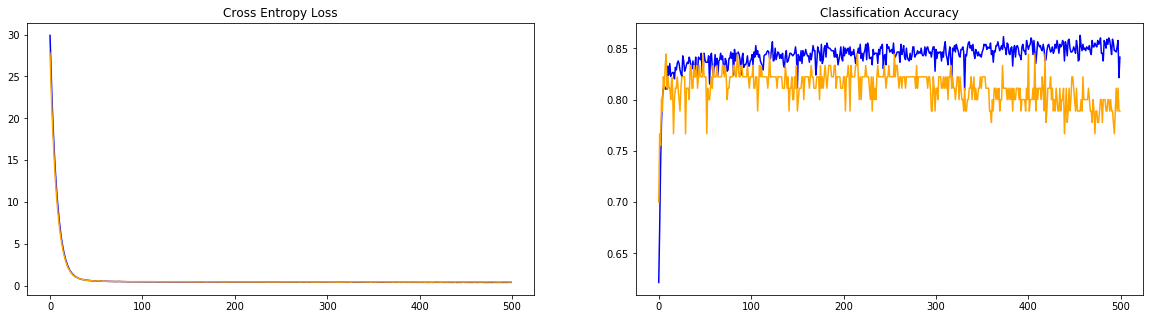

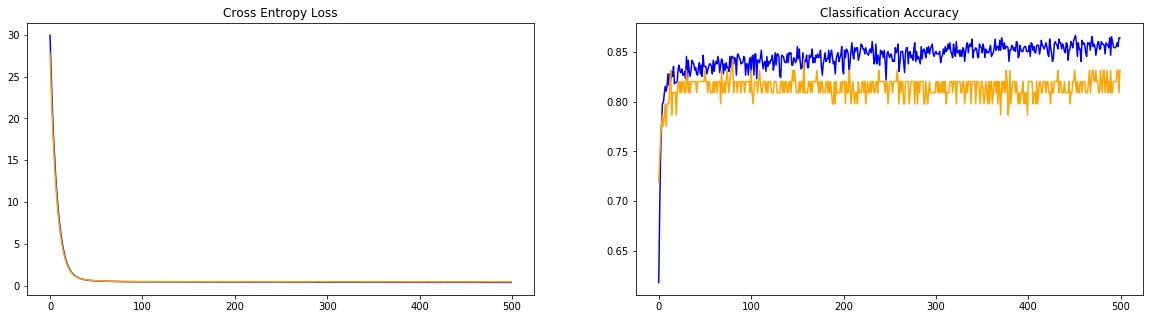

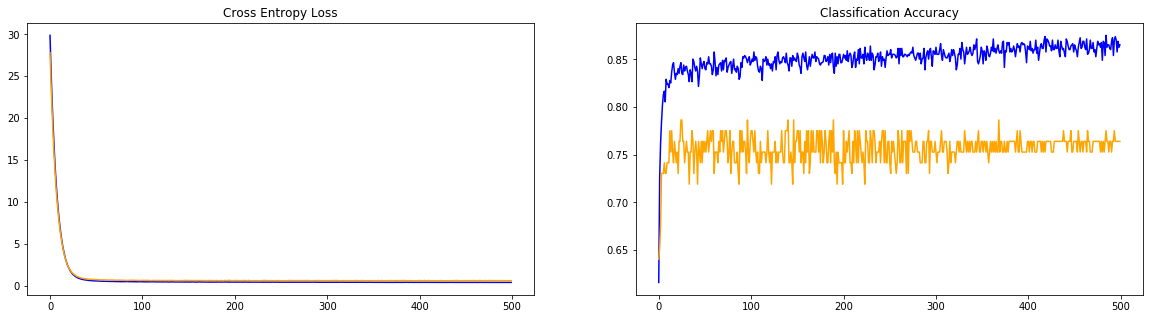

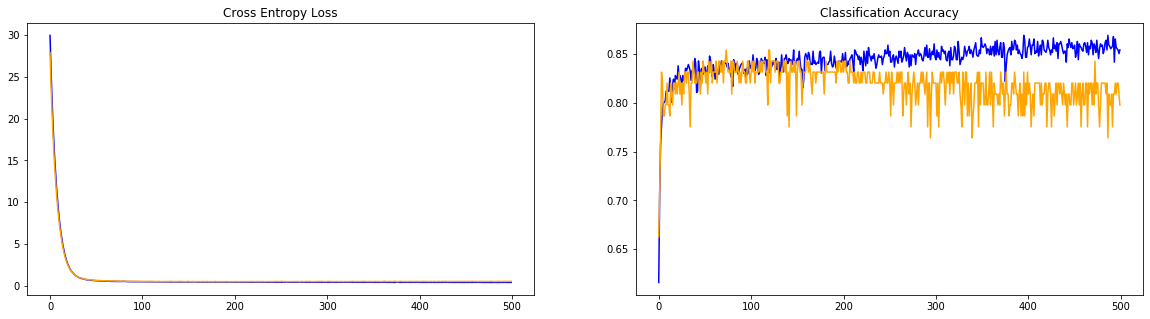

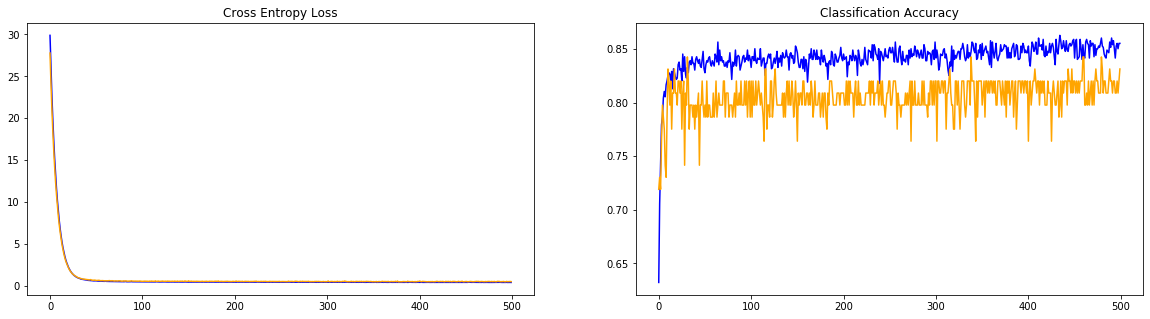

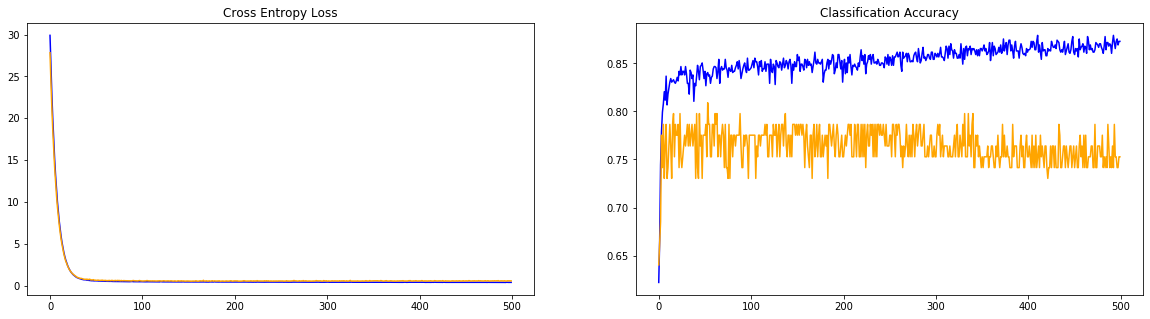

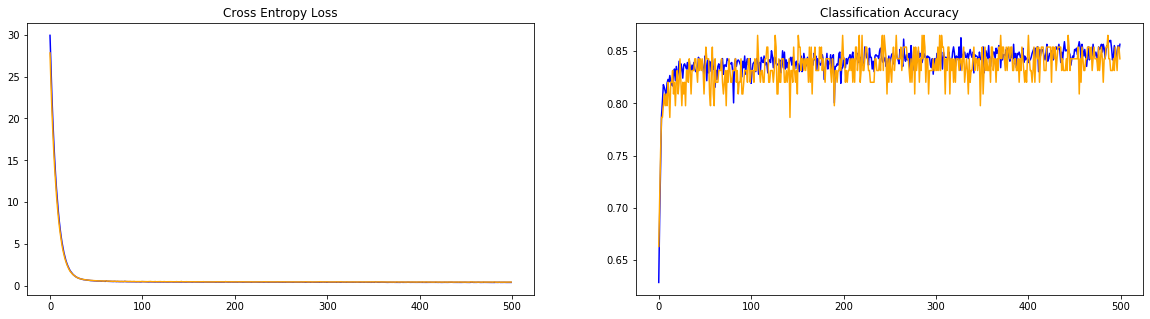

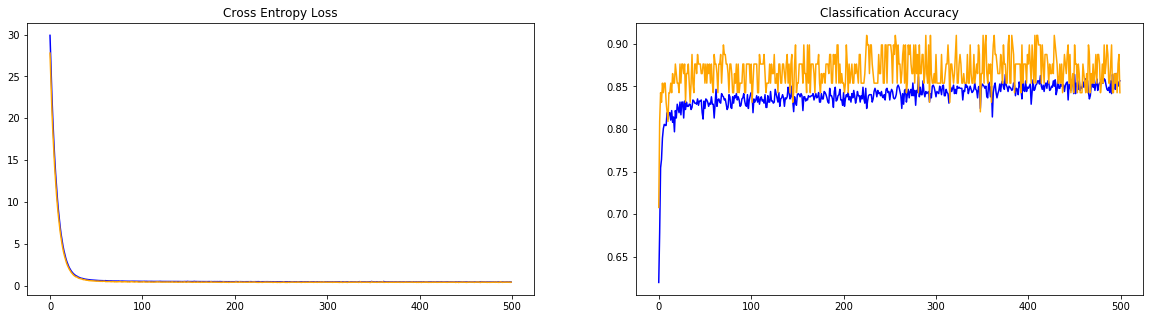

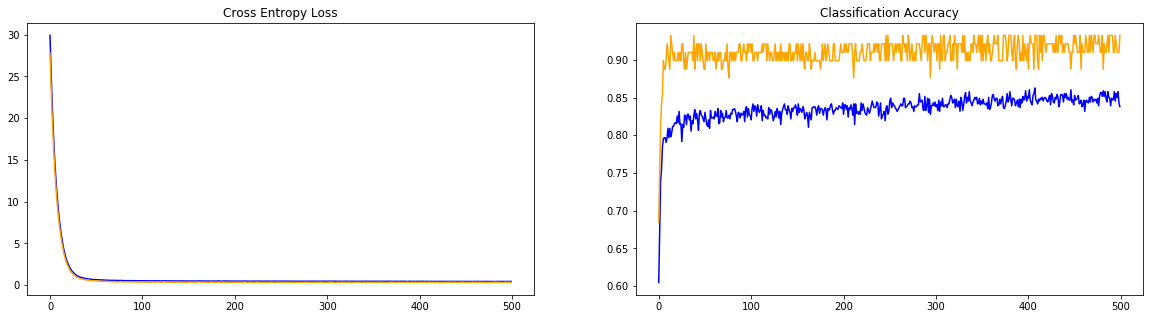

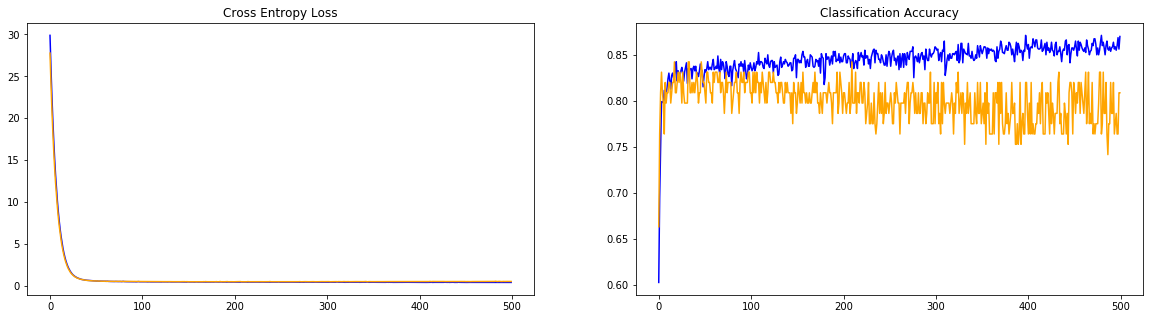

In [28]:
# evaluate
kf = KFold(n_splits=10, shuffle = True)
fold_accuracy = []
fold_loss = []
i = 1
for train_index, test_index in kf.split(trainData):        
    model = CreateModel()
    model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.0001),
             metrics = ['accuracy'])
    history = model.fit(  x = trainX[train_index],
                          y = trainY[train_index],
                          epochs = 500,
                          verbose = 2,
                          validation_data = (trainX[test_index],trainY[test_index]),
                          callbacks=[cp_callback],
                     )
    # evaluate
    test_loss, test_acc = model.evaluate(trainX[test_index],trainY[test_index],verbose = 0)    
    print('Fold: {}, test accuracy: {}, test loss: {}'.format(i,test_acc,test_loss))
    fold_accuracy.append(test_acc)
    fold_loss.append(test_loss)
    # plot lose
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.title('Cross Entropy Loss')
    plt.plot(history.history['loss'], color='blue', label='train')
    plt.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    plt.subplot(122)
    plt.title('Classification Accuracy')
    plt.plot(history.history['accuracy'], color='blue', label='train')
    plt.plot(history.history['val_accuracy'], color='orange', label='test')
    i+=1
#model.load_weights('./checkpoint.ckpt')          
avg_acc = sum(fold_accuracy)/len(fold_accuracy)
avg_loss = sum(fold_loss)/len(fold_loss)
print('avg accuracy: {}, avg loss: {}'.format(avg_acc,avg_loss))

In [29]:
# Training
model = CreateModel()
model.compile(loss = 'binary_crossentropy',
             optimizer=tf.keras.optimizers.Adam(lr = 0.00005),
             metrics = ['accuracy'])
history = model.fit(  x = trainX,
                      y = trainY,
                      epochs = 1000,
                      verbose = 2,
)        

Train on 891 samples
Epoch 1/1000
891/891 - 2s - loss: 30.6789 - accuracy: 0.6397
Epoch 2/1000
891/891 - 1s - loss: 28.5522 - accuracy: 0.6465
Epoch 3/1000
891/891 - 1s - loss: 26.5586 - accuracy: 0.7059
Epoch 4/1000
891/891 - 1s - loss: 24.6970 - accuracy: 0.7419
Epoch 5/1000
891/891 - 1s - loss: 22.9647 - accuracy: 0.7576
Epoch 6/1000
891/891 - 1s - loss: 21.3664 - accuracy: 0.7789
Epoch 7/1000
891/891 - 1s - loss: 19.8640 - accuracy: 0.7901
Epoch 8/1000
891/891 - 1s - loss: 18.4673 - accuracy: 0.8137
Epoch 9/1000
891/891 - 1s - loss: 17.1807 - accuracy: 0.7935
Epoch 10/1000
891/891 - 1s - loss: 15.9674 - accuracy: 0.8070
Epoch 11/1000
891/891 - 1s - loss: 14.8418 - accuracy: 0.8070
Epoch 12/1000
891/891 - 1s - loss: 13.7927 - accuracy: 0.8081
Epoch 13/1000
891/891 - 1s - loss: 12.8181 - accuracy: 0.8114
Epoch 14/1000
891/891 - 1s - loss: 11.9090 - accuracy: 0.8092
Epoch 15/1000
891/891 - 1s - loss: 11.0691 - accuracy: 0.8204
Epoch 16/1000
891/891 - 1s - loss: 10.2667 - accuracy: 0.8

Epoch 135/1000
891/891 - 1s - loss: 0.5029 - accuracy: 0.8440
Epoch 136/1000
891/891 - 1s - loss: 0.4999 - accuracy: 0.8361
Epoch 137/1000
891/891 - 1s - loss: 0.4972 - accuracy: 0.8451
Epoch 138/1000
891/891 - 1s - loss: 0.4980 - accuracy: 0.8406
Epoch 139/1000
891/891 - 1s - loss: 0.4980 - accuracy: 0.8339
Epoch 140/1000
891/891 - 1s - loss: 0.4949 - accuracy: 0.8440
Epoch 141/1000
891/891 - 1s - loss: 0.4996 - accuracy: 0.8451
Epoch 142/1000
891/891 - 1s - loss: 0.4979 - accuracy: 0.8440
Epoch 143/1000
891/891 - 1s - loss: 0.4987 - accuracy: 0.8384
Epoch 144/1000
891/891 - 1s - loss: 0.4944 - accuracy: 0.8429
Epoch 145/1000
891/891 - 1s - loss: 0.4995 - accuracy: 0.8305
Epoch 146/1000
891/891 - 1s - loss: 0.4936 - accuracy: 0.8373
Epoch 147/1000
891/891 - 1s - loss: 0.4961 - accuracy: 0.8361
Epoch 148/1000
891/891 - 1s - loss: 0.4953 - accuracy: 0.8429
Epoch 149/1000
891/891 - 1s - loss: 0.4973 - accuracy: 0.8339
Epoch 150/1000
891/891 - 1s - loss: 0.4984 - accuracy: 0.8339
Epoch 15

891/891 - 1s - loss: 0.4586 - accuracy: 0.8373
Epoch 268/1000
891/891 - 1s - loss: 0.4609 - accuracy: 0.8462
Epoch 269/1000
891/891 - 1s - loss: 0.4557 - accuracy: 0.8429
Epoch 270/1000
891/891 - 1s - loss: 0.4569 - accuracy: 0.8406
Epoch 271/1000
891/891 - 1s - loss: 0.4510 - accuracy: 0.8395
Epoch 272/1000
891/891 - 1s - loss: 0.4551 - accuracy: 0.8361
Epoch 273/1000
891/891 - 1s - loss: 0.4534 - accuracy: 0.8451
Epoch 274/1000
891/891 - 1s - loss: 0.4599 - accuracy: 0.8373
Epoch 275/1000
891/891 - 1s - loss: 0.4537 - accuracy: 0.8474
Epoch 276/1000
891/891 - 1s - loss: 0.4553 - accuracy: 0.8451
Epoch 277/1000
891/891 - 1s - loss: 0.4544 - accuracy: 0.8507
Epoch 278/1000
891/891 - 1s - loss: 0.4586 - accuracy: 0.8440
Epoch 279/1000
891/891 - 1s - loss: 0.4569 - accuracy: 0.8373
Epoch 280/1000
891/891 - 1s - loss: 0.4537 - accuracy: 0.8418
Epoch 281/1000
891/891 - 1s - loss: 0.4569 - accuracy: 0.8339
Epoch 282/1000
891/891 - 1s - loss: 0.4557 - accuracy: 0.8339
Epoch 283/1000
891/891 

Epoch 400/1000
891/891 - 1s - loss: 0.4355 - accuracy: 0.8530
Epoch 401/1000
891/891 - 1s - loss: 0.4315 - accuracy: 0.8496
Epoch 402/1000
891/891 - 1s - loss: 0.4382 - accuracy: 0.8373
Epoch 403/1000
891/891 - 1s - loss: 0.4350 - accuracy: 0.8530
Epoch 404/1000
891/891 - 1s - loss: 0.4350 - accuracy: 0.8451
Epoch 405/1000
891/891 - 1s - loss: 0.4404 - accuracy: 0.8474
Epoch 406/1000
891/891 - 1s - loss: 0.4390 - accuracy: 0.8462
Epoch 407/1000
891/891 - 1s - loss: 0.4342 - accuracy: 0.8451
Epoch 408/1000
891/891 - 1s - loss: 0.4361 - accuracy: 0.8462
Epoch 409/1000
891/891 - 1s - loss: 0.4324 - accuracy: 0.8451
Epoch 410/1000
891/891 - 1s - loss: 0.4331 - accuracy: 0.8474
Epoch 411/1000
891/891 - 1s - loss: 0.4395 - accuracy: 0.8485
Epoch 412/1000
891/891 - 1s - loss: 0.4398 - accuracy: 0.8485
Epoch 413/1000
891/891 - 1s - loss: 0.4331 - accuracy: 0.8541
Epoch 414/1000
891/891 - 1s - loss: 0.4430 - accuracy: 0.8440
Epoch 415/1000
891/891 - 1s - loss: 0.4327 - accuracy: 0.8474
Epoch 41

891/891 - 1s - loss: 0.4208 - accuracy: 0.8563
Epoch 533/1000
891/891 - 1s - loss: 0.4224 - accuracy: 0.8541
Epoch 534/1000
891/891 - 1s - loss: 0.4311 - accuracy: 0.8440
Epoch 535/1000
891/891 - 1s - loss: 0.4235 - accuracy: 0.8530
Epoch 536/1000
891/891 - 1s - loss: 0.4244 - accuracy: 0.8519
Epoch 537/1000
891/891 - 1s - loss: 0.4238 - accuracy: 0.8474
Epoch 538/1000
891/891 - 1s - loss: 0.4245 - accuracy: 0.8462
Epoch 539/1000
891/891 - 1s - loss: 0.4195 - accuracy: 0.8541
Epoch 540/1000
891/891 - 1s - loss: 0.4224 - accuracy: 0.8642
Epoch 541/1000
891/891 - 1s - loss: 0.4207 - accuracy: 0.8507
Epoch 542/1000
891/891 - 1s - loss: 0.4247 - accuracy: 0.8485
Epoch 543/1000
891/891 - 1s - loss: 0.4219 - accuracy: 0.8519
Epoch 544/1000
891/891 - 1s - loss: 0.4305 - accuracy: 0.8496
Epoch 545/1000
891/891 - 1s - loss: 0.4210 - accuracy: 0.8597
Epoch 546/1000
891/891 - 1s - loss: 0.4213 - accuracy: 0.8496
Epoch 547/1000
891/891 - 1s - loss: 0.4205 - accuracy: 0.8575
Epoch 548/1000
891/891 

Epoch 665/1000
891/891 - 1s - loss: 0.4162 - accuracy: 0.8563
Epoch 666/1000
891/891 - 1s - loss: 0.4118 - accuracy: 0.8597
Epoch 667/1000
891/891 - 1s - loss: 0.4156 - accuracy: 0.8563
Epoch 668/1000
891/891 - 1s - loss: 0.4126 - accuracy: 0.8586
Epoch 669/1000
891/891 - 1s - loss: 0.4240 - accuracy: 0.8474
Epoch 670/1000
891/891 - 1s - loss: 0.4182 - accuracy: 0.8519
Epoch 671/1000
891/891 - 1s - loss: 0.4166 - accuracy: 0.8530
Epoch 672/1000
891/891 - 1s - loss: 0.4133 - accuracy: 0.8563
Epoch 673/1000
891/891 - 1s - loss: 0.4214 - accuracy: 0.8586
Epoch 674/1000
891/891 - 1s - loss: 0.4144 - accuracy: 0.8631
Epoch 675/1000
891/891 - 1s - loss: 0.4155 - accuracy: 0.8653
Epoch 676/1000
891/891 - 1s - loss: 0.4199 - accuracy: 0.8631
Epoch 677/1000
891/891 - 1s - loss: 0.4186 - accuracy: 0.8552
Epoch 678/1000
891/891 - 1s - loss: 0.4164 - accuracy: 0.8530
Epoch 679/1000
891/891 - 1s - loss: 0.4148 - accuracy: 0.8586
Epoch 680/1000
891/891 - 1s - loss: 0.4188 - accuracy: 0.8563
Epoch 68

891/891 - 1s - loss: 0.4135 - accuracy: 0.8608
Epoch 798/1000
891/891 - 1s - loss: 0.4163 - accuracy: 0.8586
Epoch 799/1000
891/891 - 1s - loss: 0.4128 - accuracy: 0.8597
Epoch 800/1000
891/891 - 1s - loss: 0.4094 - accuracy: 0.8743
Epoch 801/1000
891/891 - 1s - loss: 0.4095 - accuracy: 0.8552
Epoch 802/1000
891/891 - 1s - loss: 0.4112 - accuracy: 0.8586
Epoch 803/1000
891/891 - 1s - loss: 0.4074 - accuracy: 0.8664
Epoch 804/1000
891/891 - 1s - loss: 0.4109 - accuracy: 0.8563
Epoch 805/1000
891/891 - 1s - loss: 0.4112 - accuracy: 0.8586
Epoch 806/1000
891/891 - 1s - loss: 0.4085 - accuracy: 0.8552
Epoch 807/1000
891/891 - 1s - loss: 0.4075 - accuracy: 0.8597
Epoch 808/1000
891/891 - 1s - loss: 0.4111 - accuracy: 0.8451
Epoch 809/1000
891/891 - 1s - loss: 0.4096 - accuracy: 0.8552
Epoch 810/1000
891/891 - 1s - loss: 0.4118 - accuracy: 0.8642
Epoch 811/1000
891/891 - 1s - loss: 0.4037 - accuracy: 0.8642
Epoch 812/1000
891/891 - 1s - loss: 0.4140 - accuracy: 0.8462
Epoch 813/1000
891/891 

Epoch 930/1000
891/891 - 1s - loss: 0.4029 - accuracy: 0.8631
Epoch 931/1000
891/891 - 1s - loss: 0.4080 - accuracy: 0.8552
Epoch 932/1000
891/891 - 1s - loss: 0.4106 - accuracy: 0.8563
Epoch 933/1000
891/891 - 1s - loss: 0.4017 - accuracy: 0.8620
Epoch 934/1000
891/891 - 1s - loss: 0.4040 - accuracy: 0.8653
Epoch 935/1000
891/891 - 1s - loss: 0.4078 - accuracy: 0.8563
Epoch 936/1000
891/891 - 1s - loss: 0.4021 - accuracy: 0.8586
Epoch 937/1000
891/891 - 1s - loss: 0.4019 - accuracy: 0.8586
Epoch 938/1000
891/891 - 1s - loss: 0.4067 - accuracy: 0.8676
Epoch 939/1000
891/891 - 1s - loss: 0.4059 - accuracy: 0.8597
Epoch 940/1000
891/891 - 1s - loss: 0.4008 - accuracy: 0.8631
Epoch 941/1000
891/891 - 1s - loss: 0.4089 - accuracy: 0.8563
Epoch 942/1000
891/891 - 1s - loss: 0.4002 - accuracy: 0.8709
Epoch 943/1000
891/891 - 1s - loss: 0.4028 - accuracy: 0.8620
Epoch 944/1000
891/891 - 1s - loss: 0.4059 - accuracy: 0.8575
Epoch 945/1000
891/891 - 1s - loss: 0.4051 - accuracy: 0.8631
Epoch 94

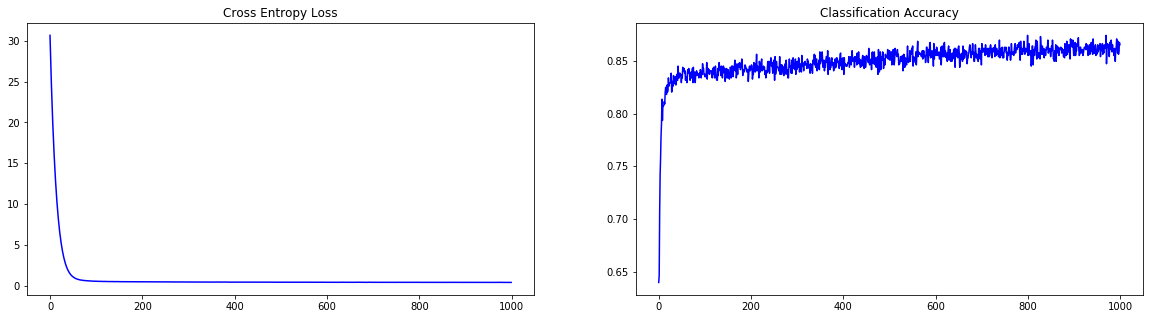

In [30]:
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')

# plot accuracy
plt.subplot(122)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')


In [31]:
# predictions
predictions = model.predict_classes(testX).reshape(len(testX))
# write csv file
submission =pd.DataFrame({'PassengerId':pId,'Survived':predictions})
submission.to_csv('Titanic Predictions DL.csv',index = False)

In [32]:
# Random forest
tree_num = 700
depth = 10
split = 10
forest = RandomForestClassifier(n_estimators = tree_num,max_depth = depth,min_samples_split = split)

# KFOLD
RunKfold(forest,trainX,trainY)

# build model and training
Train(forest,trainX,trainY)

# Predict and write CSV
Prediction(forest,testX,"Titanic Predictions RF.csv")

Fold 1 : 0.7666666666666667
Fold 2 : 0.8539325842696629
Fold 3 : 0.7528089887640449
Fold 4 : 0.8314606741573034
Fold 5 : 0.8314606741573034
Fold 6 : 0.8089887640449438
Fold 7 : 0.8539325842696629
Fold 8 : 0.7752808988764045
Fold 9 : 0.8314606741573034
Fold 10 : 0.7865168539325843
Avg acc : 0.809250936329588
Train accuracy : 0.8641975308641975
Write to csv finished!


In [33]:
# Decisiton Tree
depth = 7
dt = tree.DecisionTreeClassifier(max_depth = depth)

# KFOLD
RunKfold(dt,trainX,trainY)

# build model and training
Train(dt,trainX,trainY)

# Predict and write CSV
Prediction(dt,testX,"Titanic Predictions DT.csv")

Fold 1 : 0.7888888888888889
Fold 2 : 0.8314606741573034
Fold 3 : 0.8314606741573034
Fold 4 : 0.8314606741573034
Fold 5 : 0.7752808988764045
Fold 6 : 0.797752808988764
Fold 7 : 0.7528089887640449
Fold 8 : 0.8426966292134831
Fold 9 : 0.8426966292134831
Fold 10 : 0.8089887640449438
Avg acc : 0.8103495630461923
Train accuracy : 0.8630751964085297
Write to csv finished!


In [34]:
# SVM
kernel = 'rbf'
gamma = 'scale'
C = 1
svm = SVC(kernel = kernel,gamma = gamma,C = C)


# KFOLD
RunKfold(svm,trainX,trainY)

# build model and training
Train(svm,trainX,trainY)

# Predict and write CSV
Prediction(svm,testX,"Titanic Predictions SVM.csv")

Fold 1 : 0.8111111111111111
Fold 2 : 0.8764044943820225
Fold 3 : 0.797752808988764
Fold 4 : 0.8539325842696629
Fold 5 : 0.7640449438202247
Fold 6 : 0.8539325842696629
Fold 7 : 0.8089887640449438
Fold 8 : 0.8651685393258427
Fold 9 : 0.7865168539325843
Fold 10 : 0.8539325842696629
Avg acc : 0.8271785268414481
Train accuracy : 0.8383838383838383
Write to csv finished!


In [35]:
# knn
neighbors = 10

knn = KNeighborsClassifier(n_neighbors = neighbors)
# KFOLD
RunKfold(knn,trainX,trainY)

# build model and training
Train(knn,trainX,trainY)

# Predict and write CSV
Prediction(knn,testX,"Titanic Predictions KNN.csv")

Fold 1 : 0.8222222222222222
Fold 2 : 0.8876404494382022
Fold 3 : 0.7752808988764045
Fold 4 : 0.7752808988764045
Fold 5 : 0.7865168539325843
Fold 6 : 0.797752808988764
Fold 7 : 0.7865168539325843
Fold 8 : 0.8426966292134831
Fold 9 : 0.7752808988764045
Fold 10 : 0.7640449438202247
Avg acc : 0.8013233458177277
Train accuracy : 0.819304152637486
Write to csv finished!


In [36]:
# AdaBoost
tree_num = 1000

boost = AdaBoostClassifier()
# KFOLD
RunKfold(boost,trainX,trainY)

# build model and training
Train(boost,trainX,trainY)

# Predict and write CSV
Prediction(boost,testX,"Titanic Predictions Adaboost.csv")

Fold 1 : 0.9111111111111111
Fold 2 : 0.8089887640449438
Fold 3 : 0.7752808988764045
Fold 4 : 0.8089887640449438
Fold 5 : 0.7752808988764045
Fold 6 : 0.8426966292134831
Fold 7 : 0.7752808988764045
Fold 8 : 0.8539325842696629
Fold 9 : 0.797752808988764
Fold 10 : 0.8202247191011236
Avg acc : 0.8169538077403248
Train accuracy : 0.8327721661054994
Write to csv finished!


In [37]:
# LogisticRegression

logreg = LogisticRegression(solver  = 'lbfgs')
# KFOLD
RunKfold(logreg,trainX,trainY)

# build model and training
Train(logreg,trainX,trainY)

# Predict and write CSV
Prediction(logreg,testX,"Titanic Predictions LogReg.csv")

Fold 1 : 0.8
Fold 2 : 0.8314606741573034
Fold 3 : 0.8202247191011236
Fold 4 : 0.9213483146067416
Fold 5 : 0.8202247191011236
Fold 6 : 0.797752808988764
Fold 7 : 0.8089887640449438
Fold 8 : 0.8539325842696629
Fold 9 : 0.8426966292134831
Fold 10 : 0.7865168539325843
Avg acc : 0.828314606741573
Train accuracy : 0.8338945005611672
Write to csv finished!
